<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/WESAD_EMPATICA_CNN_LOSO_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample

In [ ]:
zip_path = "/content/drive/My Drive/WESAD/WESAD.zip"
extract_dir = "/content/WESAD_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Estrazione completata.")

Estrazione completata.


In [ ]:
pkl_files = []
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".pkl"):
            pkl_files.append(os.path.join(root, file))

print(f"Trovati {len(pkl_files)} file .pkl")

Trovati 15 file .pkl


In [ ]:
pkl_files

['/content/WESAD_data/WESAD/S7/S7.pkl',
 '/content/WESAD_data/WESAD/S13/S13.pkl',
 '/content/WESAD_data/WESAD/S14/S14.pkl',
 '/content/WESAD_data/WESAD/S4/S4.pkl',
 '/content/WESAD_data/WESAD/S10/S10.pkl',
 '/content/WESAD_data/WESAD/S11/S11.pkl',
 '/content/WESAD_data/WESAD/S16/S16.pkl',
 '/content/WESAD_data/WESAD/S2/S2.pkl',
 '/content/WESAD_data/WESAD/S5/S5.pkl',
 '/content/WESAD_data/WESAD/S9/S9.pkl',
 '/content/WESAD_data/WESAD/S15/S15.pkl',
 '/content/WESAD_data/WESAD/S3/S3.pkl',
 '/content/WESAD_data/WESAD/S8/S8.pkl',
 '/content/WESAD_data/WESAD/S17/S17.pkl',
 '/content/WESAD_data/WESAD/S6/S6.pkl']

In [ ]:
def load_all_subjects_wrist_dataframe(subject_ids, target_freq=64):
    all_data = []

    # Frequenze originali dei segnali wrist
    freq_map = {
        'ACC': 32,
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4
    }
    original_label_freq = 700  # frequenza delle label

    for subject_id in subject_ids:
        file_path = f"/content/WESAD_data/WESAD/{subject_id}/{subject_id}.pkl"

        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')

        wrist = data['signal']['wrist']
        label = data['label']

        # Resample segnali
        acc = wrist['ACC']
        bvp = wrist['BVP']
        eda = wrist['EDA']
        temp = wrist['TEMP']

        acc_resampled = resample(acc, int(len(acc) * target_freq / freq_map['ACC']))
        bvp_resampled = resample(bvp, int(len(bvp) * target_freq / freq_map['BVP'])).squeeze()
        eda_resampled = resample(eda, int(len(eda) * target_freq / freq_map['EDA'])).squeeze()
        temp_resampled = resample(temp, int(len(temp) * target_freq / freq_map['TEMP'])).squeeze()

        # Downsample delle label da 700 Hz a 64 Hz
        target_len = min(len(bvp_resampled), len(eda_resampled), len(temp_resampled), acc_resampled.shape[0])
        label_resampled = resample(label, target_len).round().astype(int)

        # Creazione del DataFrame
        df = pd.DataFrame({
            'acc1': acc_resampled[:target_len, 0],
            'acc2': acc_resampled[:target_len, 1],
            'acc3': acc_resampled[:target_len, 2],
            'bvp': bvp_resampled[:target_len],
            'eda': eda_resampled[:target_len],
            'temp': temp_resampled[:target_len],
            'label': label_resampled[:target_len],
            'subject': [subject_id] * target_len
        })

        # Filtra solo label 1 (baseline) e 2 (stress)
        df = df[df['label'].isin([1, 2])].reset_index(drop=True)

        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
subject_ids = ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]

df = load_all_subjects_wrist_dataframe(subject_ids)

In [ ]:
print("Shape of df:", df.shape)
df.head()

Shape of df: (1765022, 8)


,acc1,acc2,acc3,bvp,eda,temp,label,subject
0,39.632707,27.934275,29.026543,-109.34,1.637743,35.809888,1,S2
1,31.000000,27.000000,28.000000,-102.80,1.635583,35.809859,1,S2
2,27.763127,26.982961,25.535968,-96.55,1.633773,35.809835,1,S2
3,29.000000,27.000000,27.000000,-90.06,1.632363,35.809819,1,S2
4,28.729609,26.571029,33.415067,-83.19,1.631390,35.809809,1,S2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765022 entries, 0 to 1765021
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   label    int64  
 7   subject  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 107.7+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp,label
count,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06,1.765022e+06
mean,1.535957e+01,-6.201214e+00,8.996315e+00,1.357649e-02,2.083079e+00,3.309247e+01,1.361389e+00
std,4.294329e+01,2.986499e+01,3.132591e+01,6.748601e+01,2.789003e+00,1.447107e+00,4.804032e-01
min,-1.424491e+02,-1.404826e+02,-1.483539e+02,-1.617860e+03,7.319605e-02,2.932185e+01,1.000000e+00
25%,-2.997185e+01,-2.700567e+01,-8.000000e+00,-1.721000e+01,3.031738e-01,3.247004e+01,1.000000e+00
50%,3.385162e+01,-8.000000e+00,1.200000e+01,2.300000e+00,9.864967e-01,3.323547e+01,1.000000e+00
75%,5.300000e+01,1.100000e+01,3.300000e+01,1.864000e+01,2.891560e+00,3.399992e+01,2.000000e+00
max,1.763469e+02,1.363099e+02,1.595612e+02,1.789000e+03,1.594567e+01,3.597752e+01,2.000000e+00


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2+df['acc2']**2+df['acc3']**2)
df = df.drop(columns = ['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
df.head()

,bvp,eda,temp,label,subject,acc_mag
0,-109.34,1.637743,35.809888,1,S2,56.512082
1,-102.80,1.635583,35.809859,1,S2,49.739320
2,-96.55,1.633773,35.809835,1,S2,46.378412
3,-90.06,1.632363,35.809819,1,S2,47.947888
4,-83.19,1.631390,35.809809,1,S2,51.458495


In [ ]:
df['label'] = df['label'].map({1: 0, 2: 1}).astype(int)

In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Frequenza Assoluta': freq_assolute,
    'Frequenza Relativa (%)': freq_relative.round(2)*100
})

frequency_table

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,1127162,64.0
1,637860,36.0


In [ ]:
df.isna().sum()

,0
bvp,0
eda,0
temp,0
label,0
subject,0
acc_mag,0


In [ ]:
def plot_segnali_per_soggetto(df, segnali=None, n_points=None):

    if segnali is None:
        segnali = ['acc_mag', 'bvp', 'eda', 'temp']

    soggetti = df['subject'].unique()

    for soggetto in soggetti:
        df_soggetto = df[df['subject'] == soggetto]
        print(f"\n Soggetto: {soggetto}")

        for segnale in segnali:

            baseline = df_soggetto[df_soggetto['label'] == 0][segnale].values
            stress = df_soggetto[df_soggetto['label'] == 1][segnale].values

            if n_points is not None:
                baseline = baseline[:n_points]
                stress = stress[:n_points]

            plt.figure(figsize=(15, 3))
            plt.plot(baseline, color='green', label='Baseline', linewidth=0.8)
            plt.plot(range(len(baseline), len(baseline) + len(stress)), stress, color='red', label='Stress', linewidth=0.8)
            plt.title(f"Soggetto: {soggetto} - Segnale: {segnale.upper()}", fontsize=14)
            plt.xlabel("Campioni")
            plt.ylabel("Ampiezza")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


 Soggetto: S2


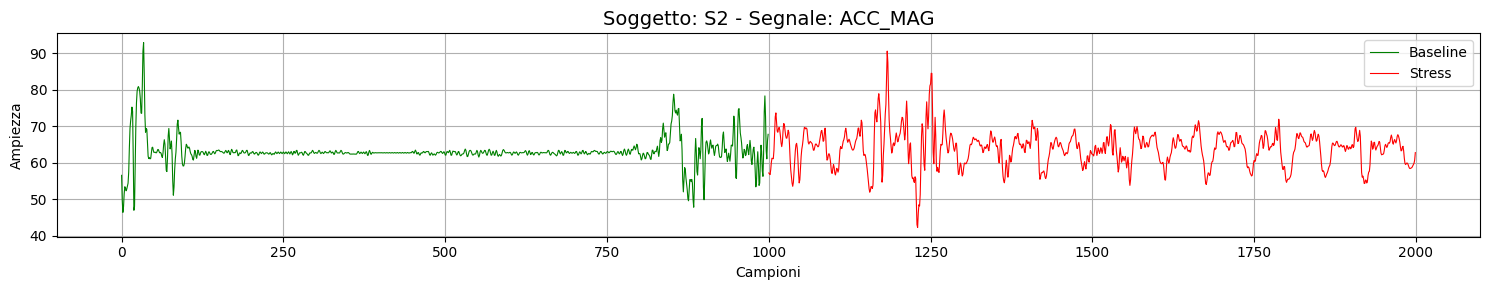

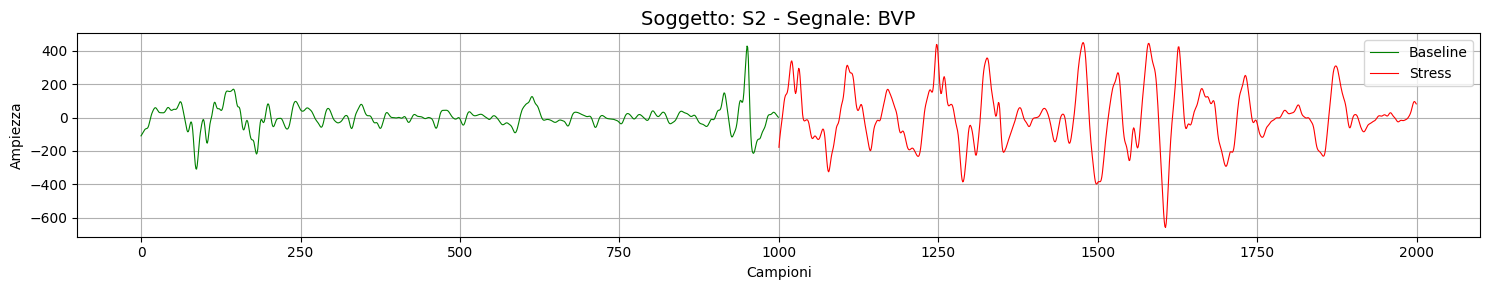

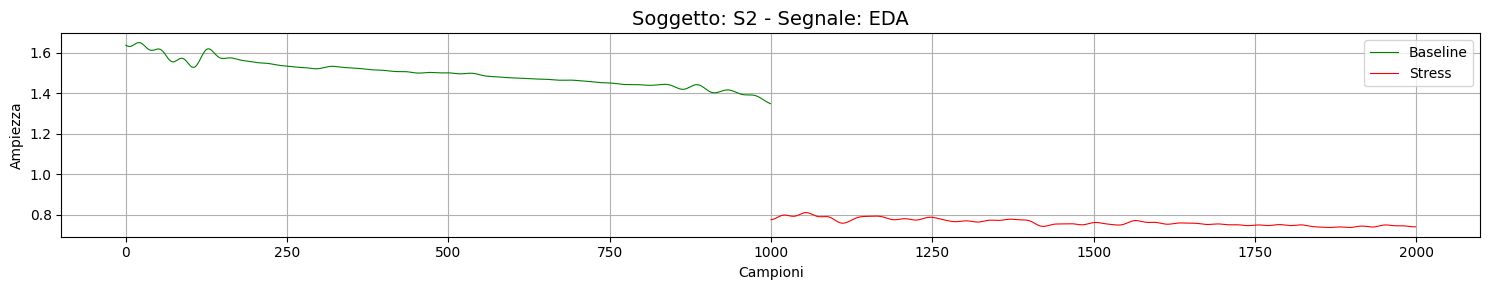

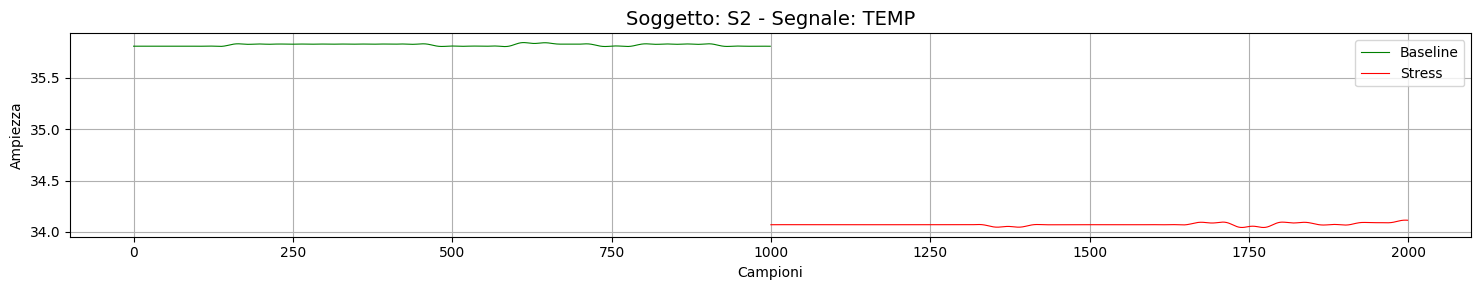


 Soggetto: S3


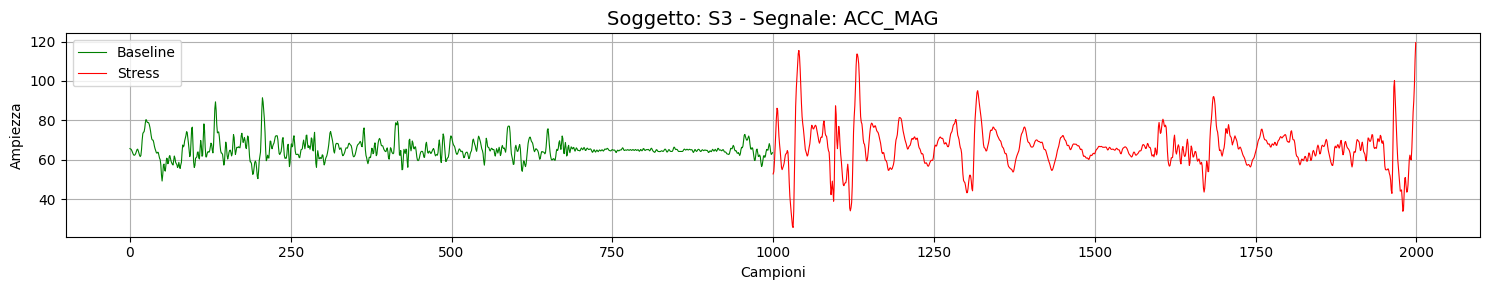

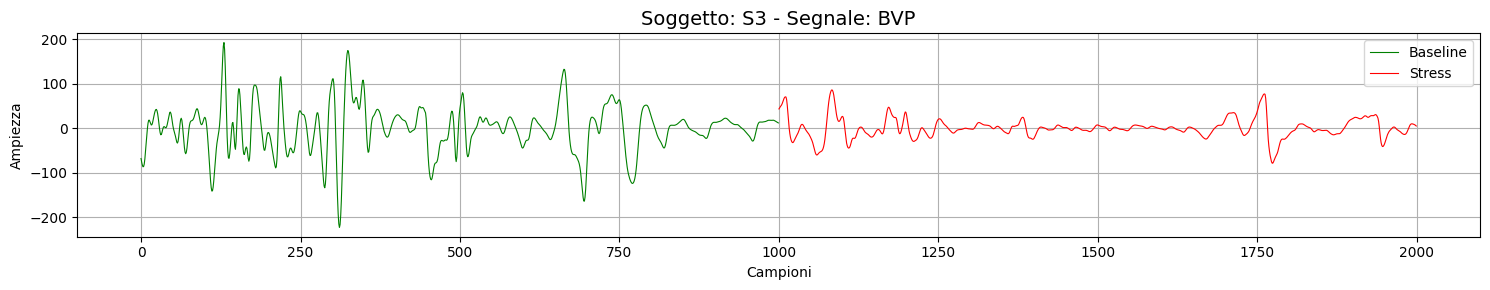

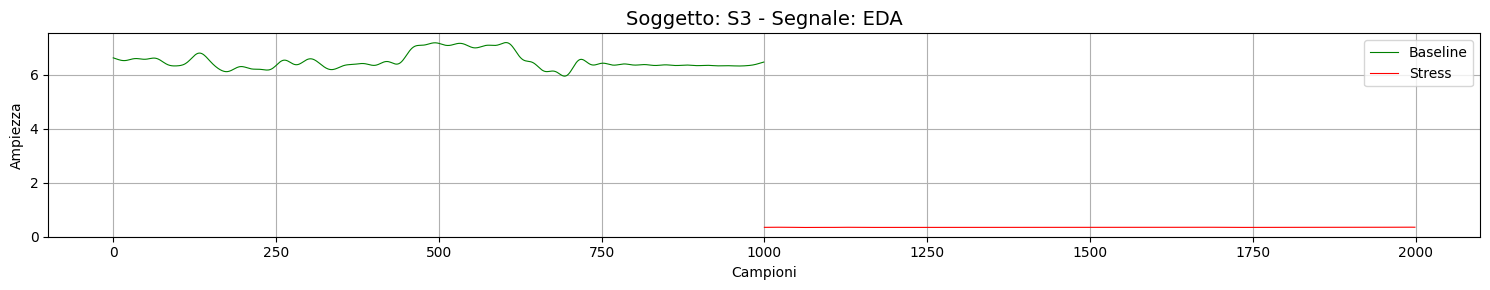

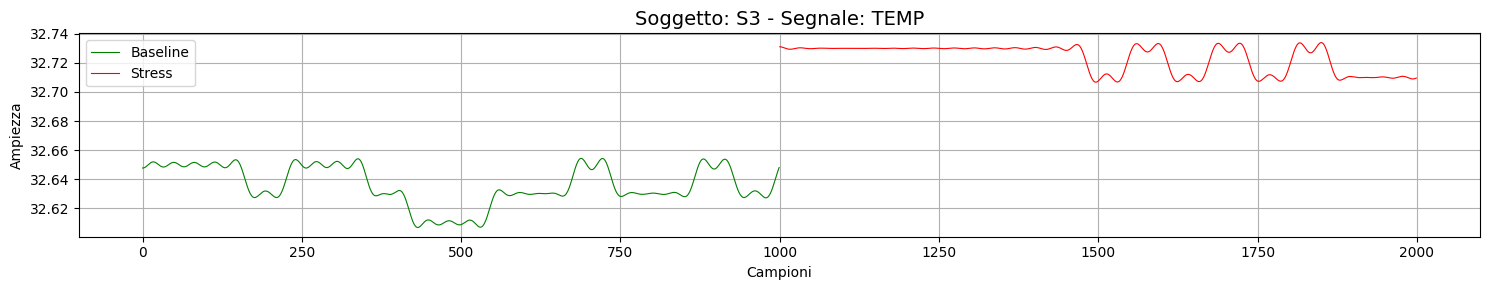


 Soggetto: S4


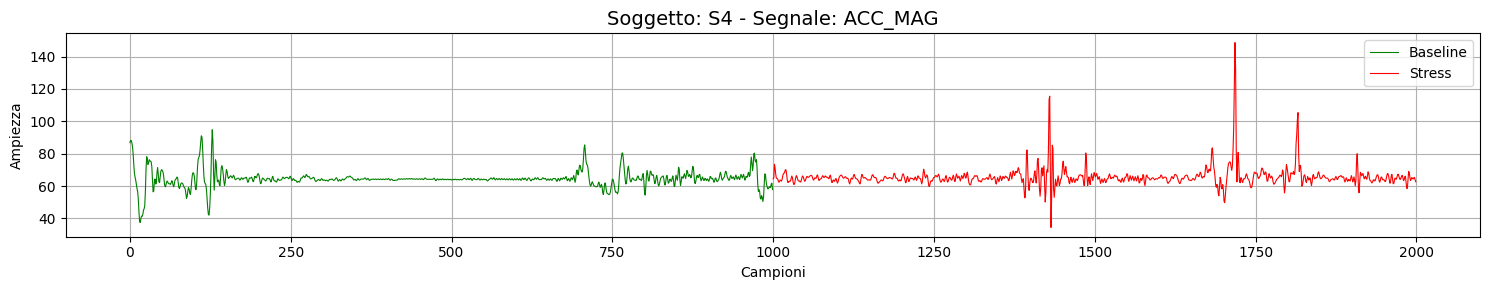

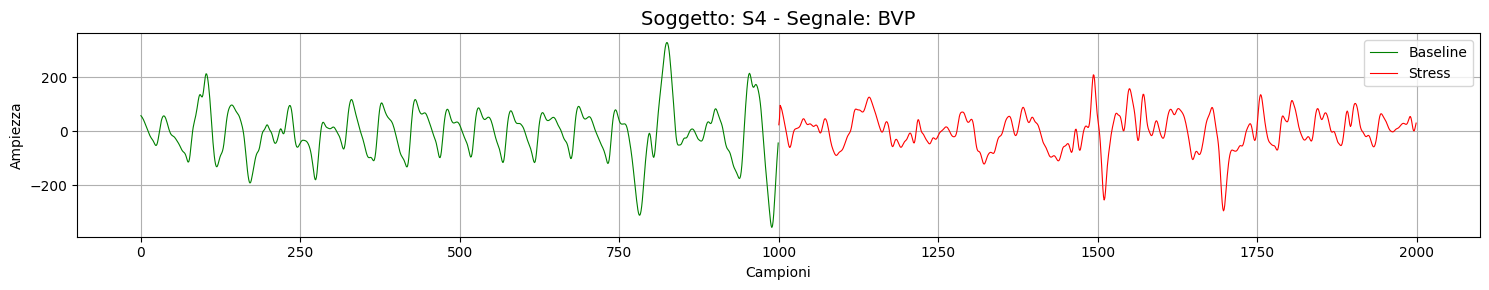

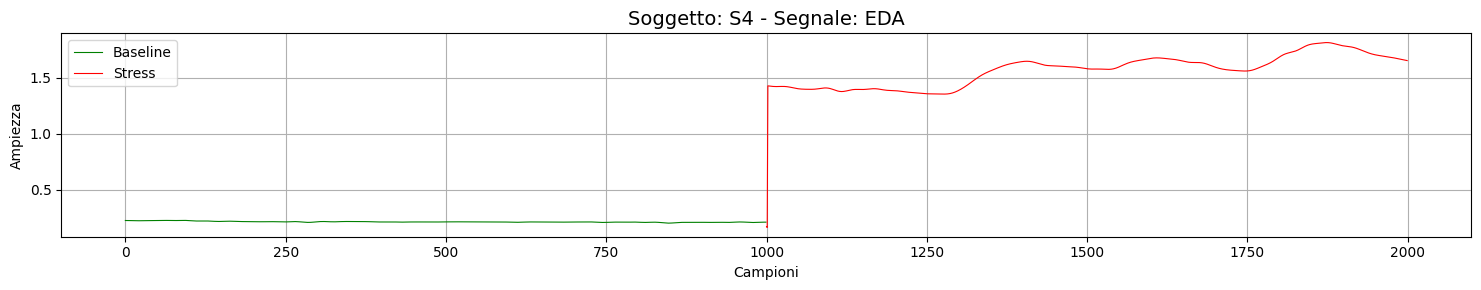

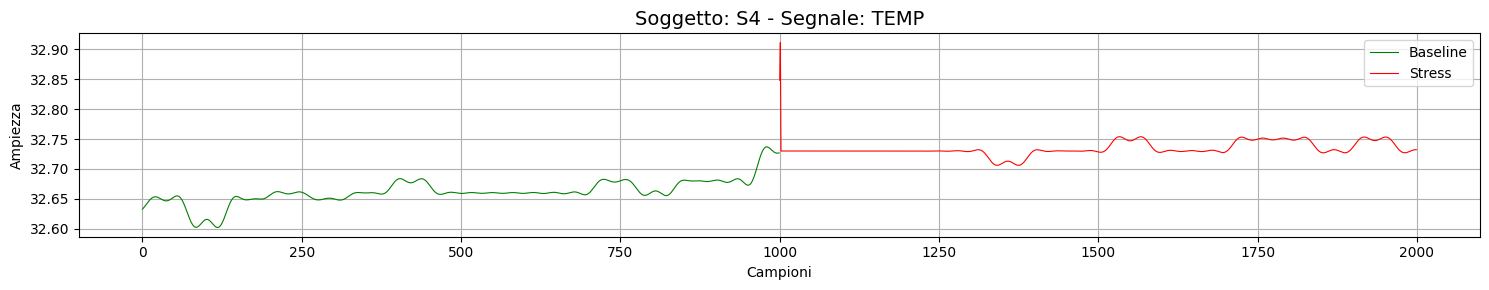


 Soggetto: S5


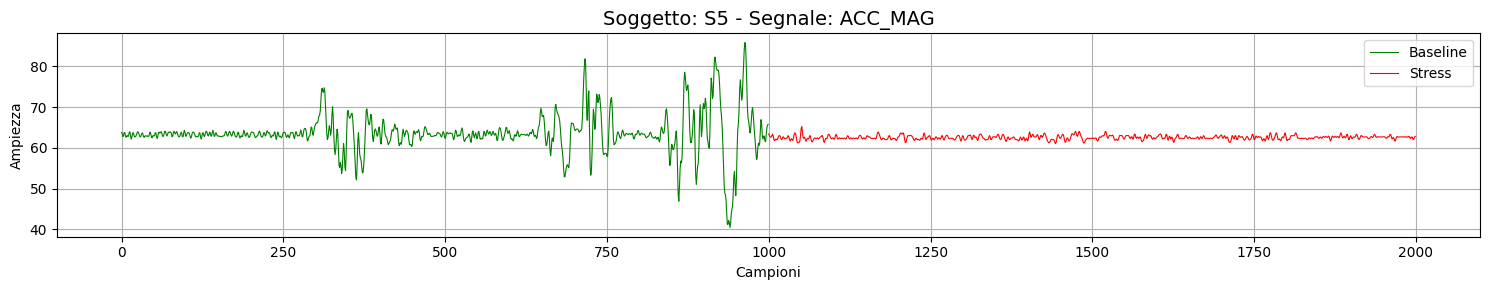

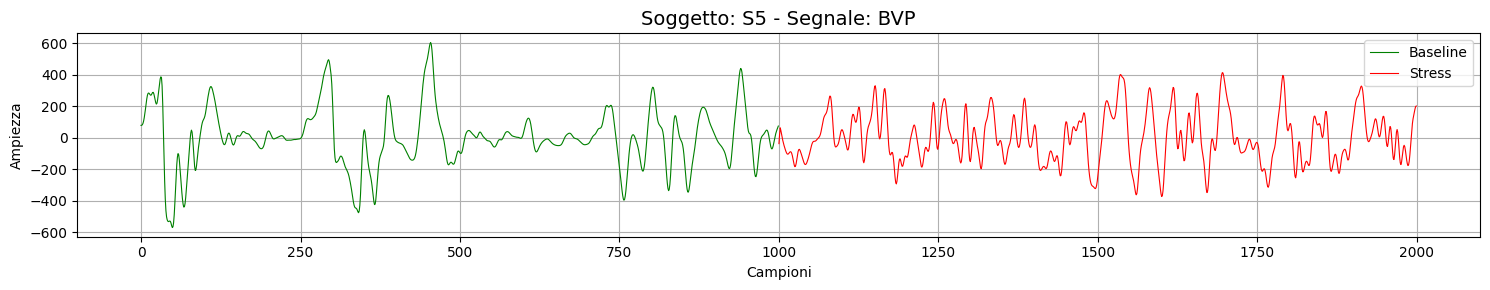

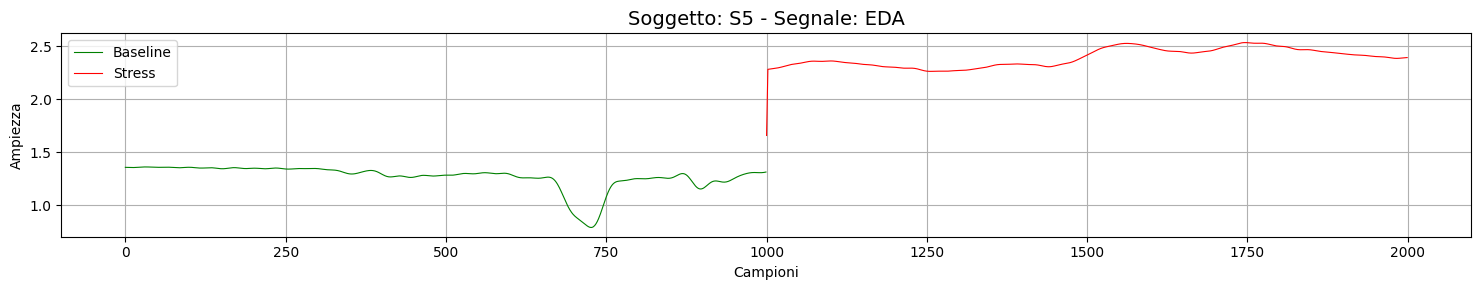

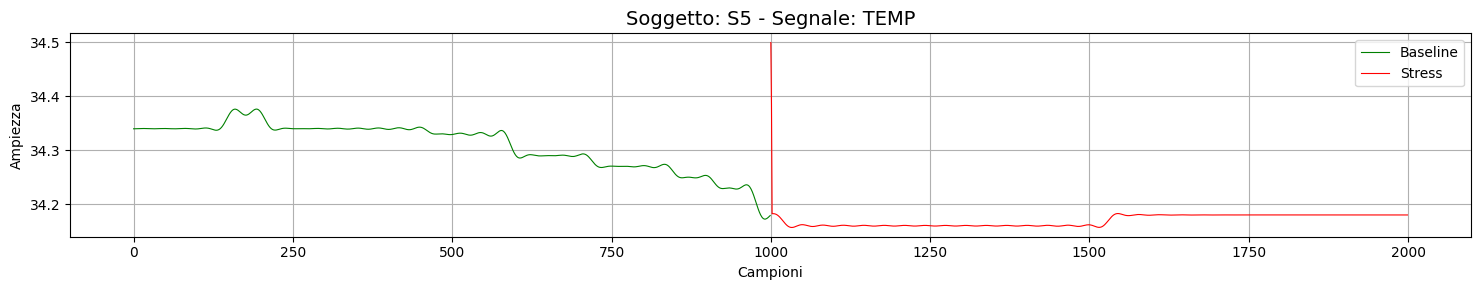


 Soggetto: S6


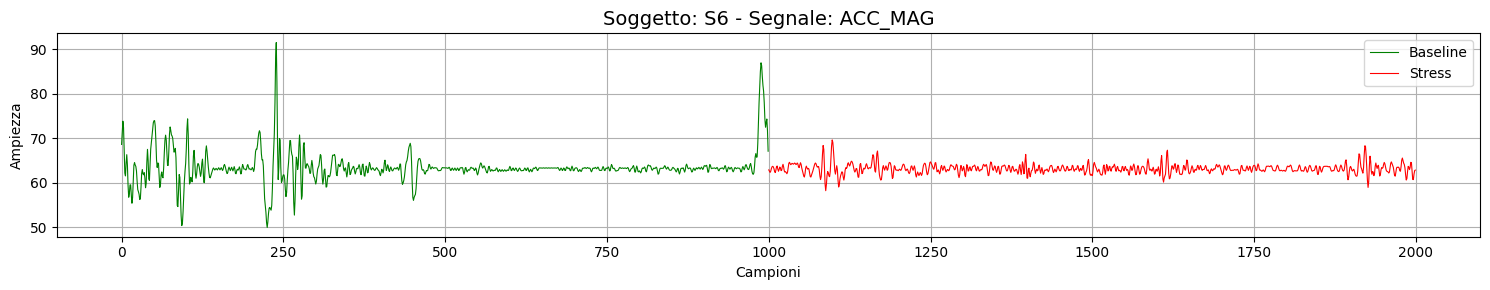

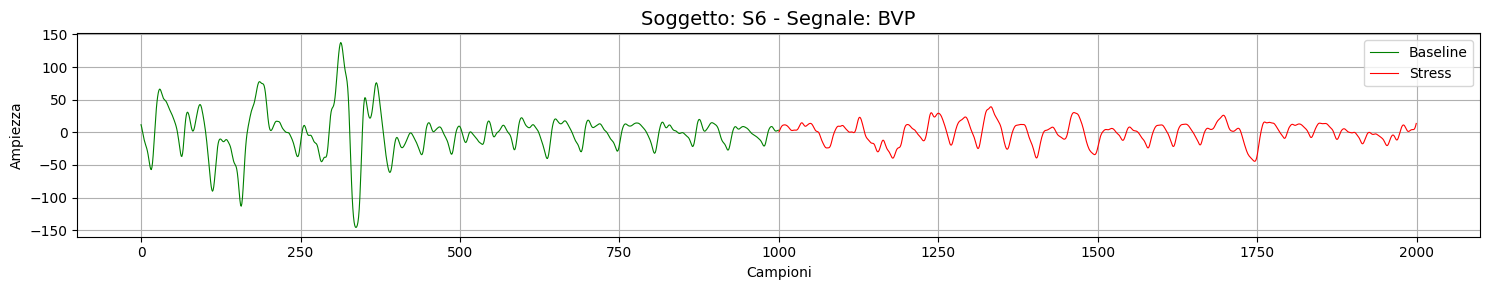

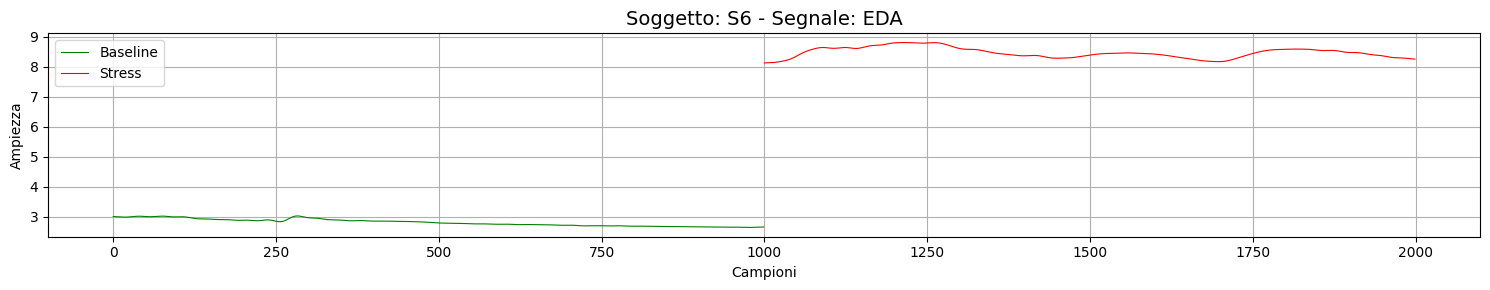

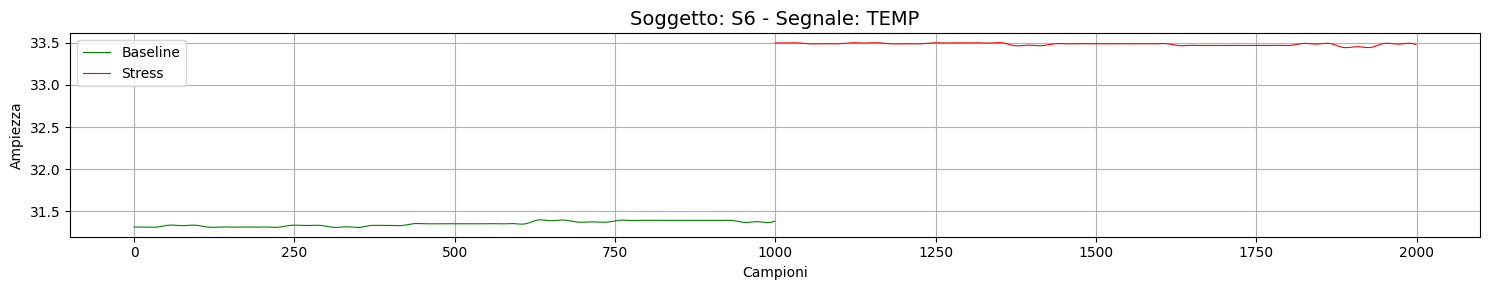


 Soggetto: S7


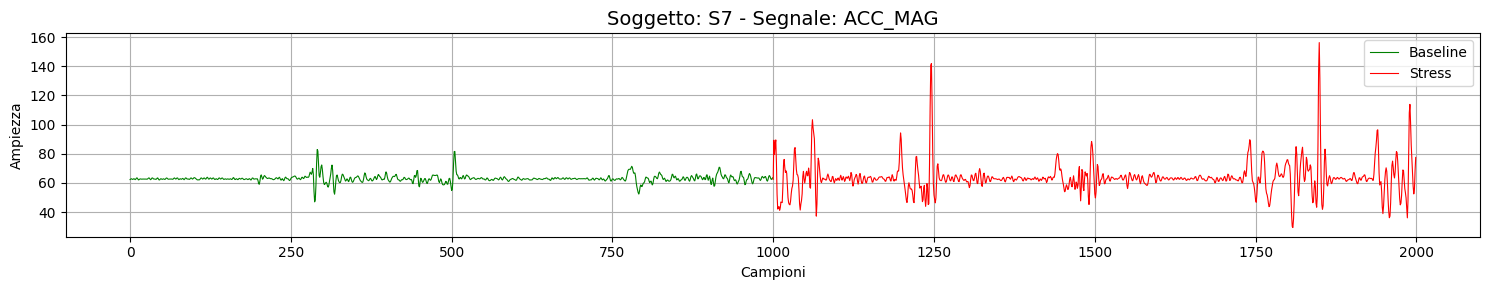

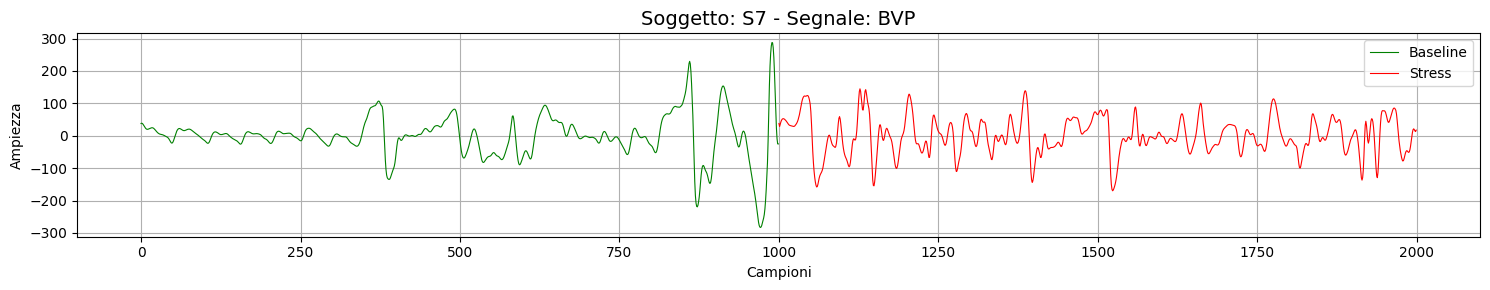

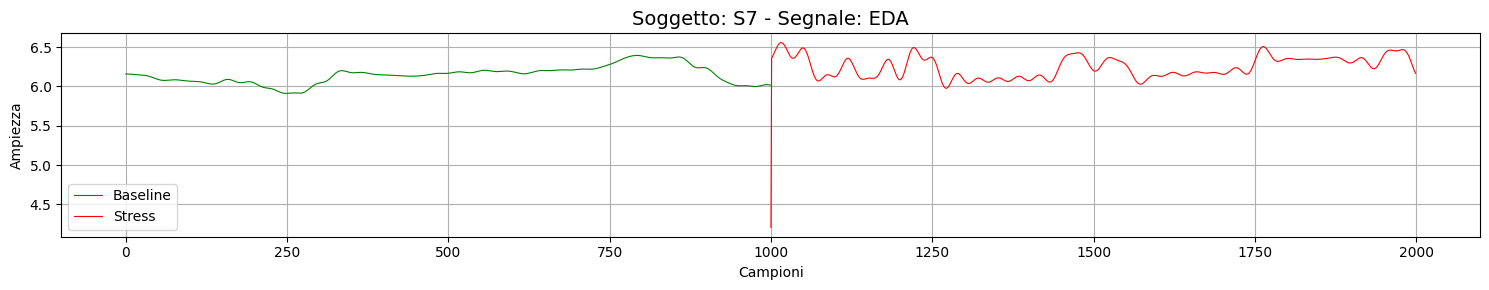

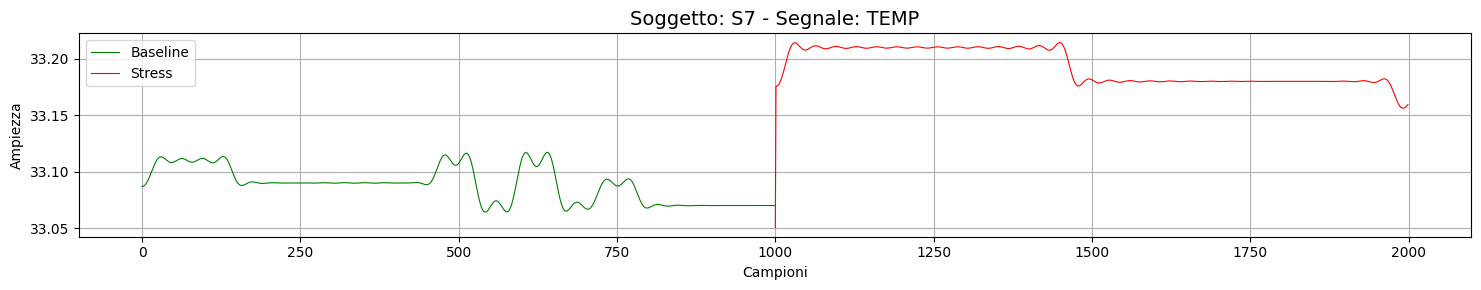


 Soggetto: S8


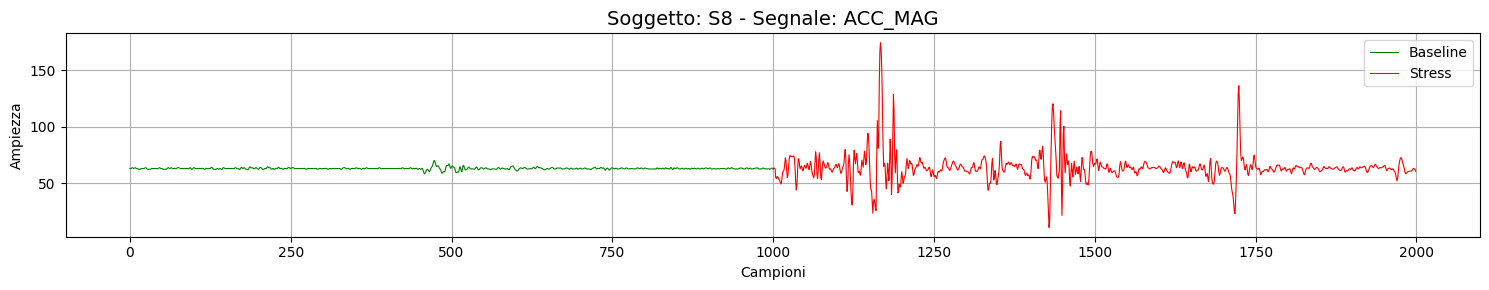

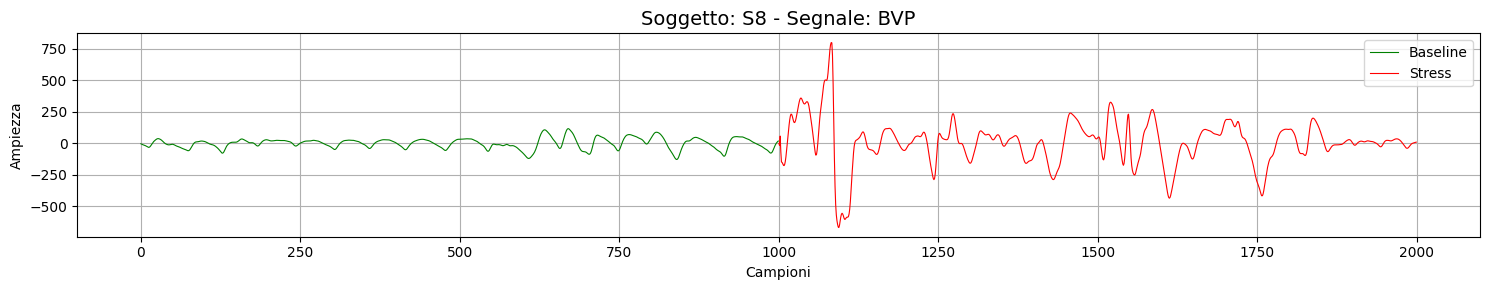

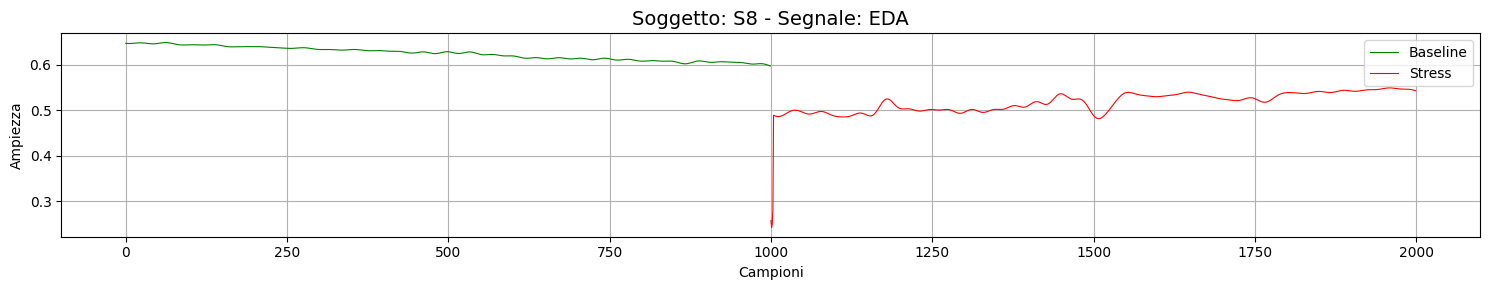

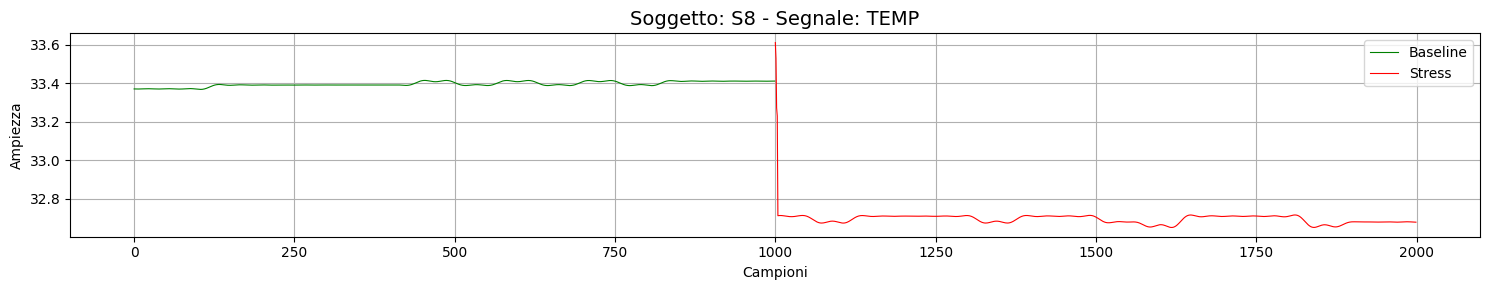


 Soggetto: S9


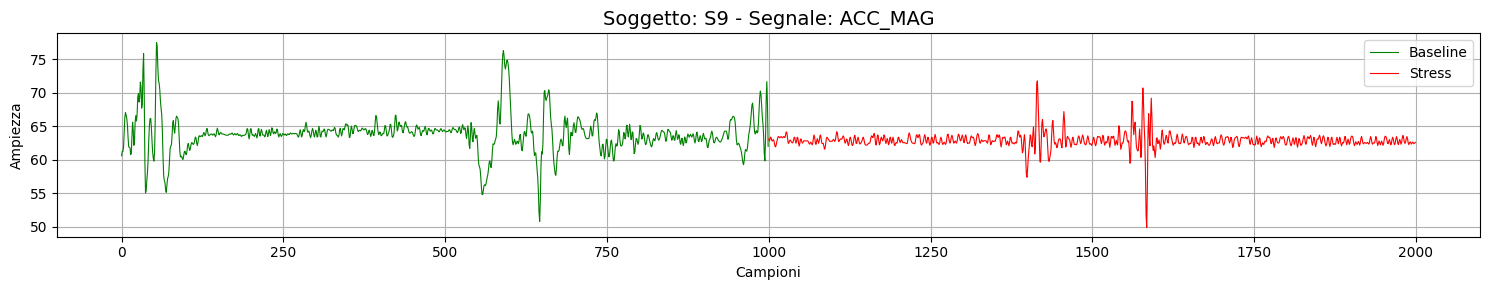

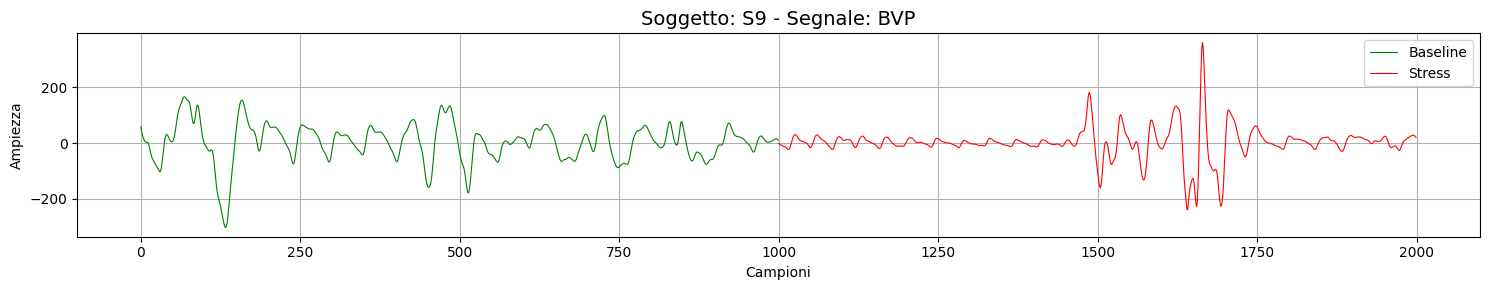

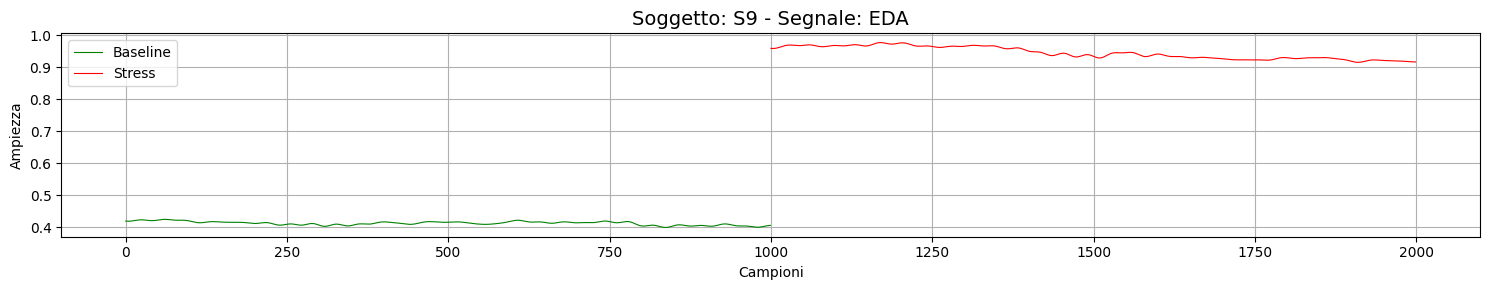

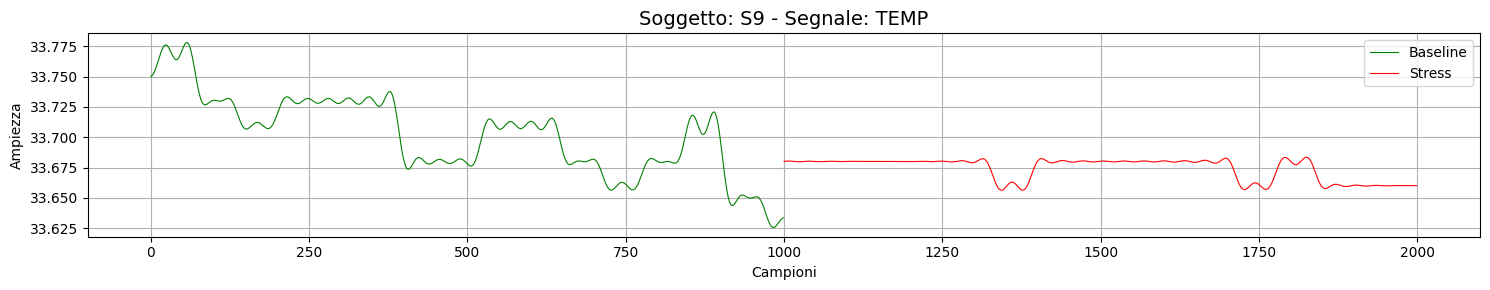


 Soggetto: S10


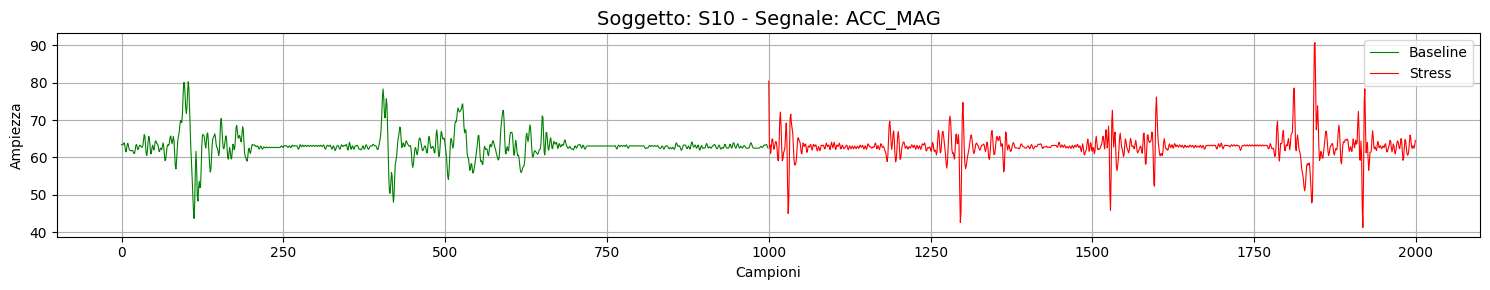

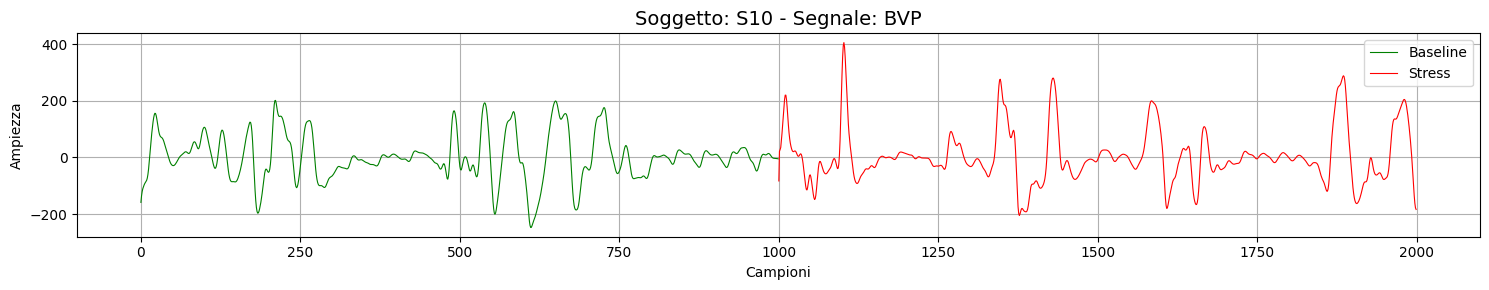

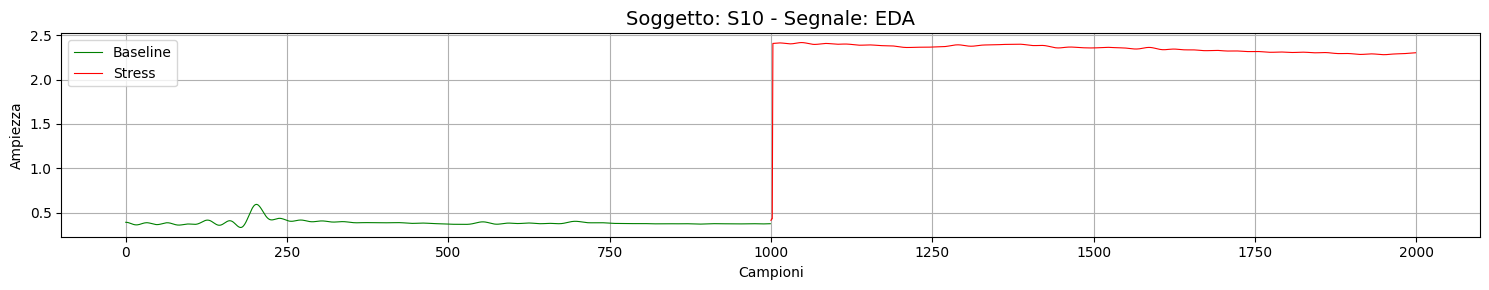

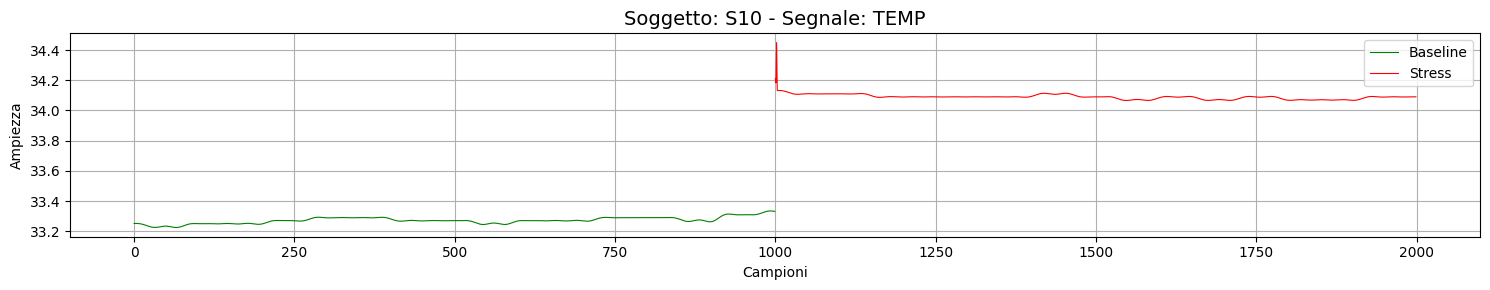


 Soggetto: S11


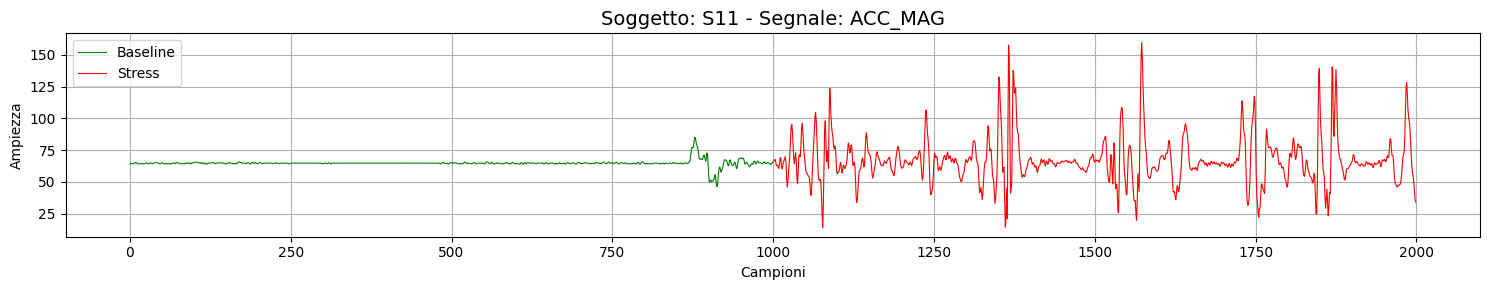

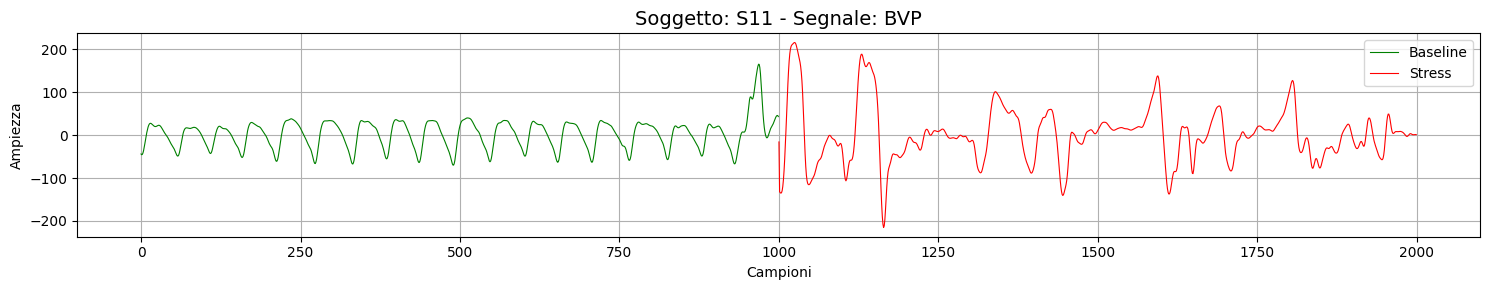

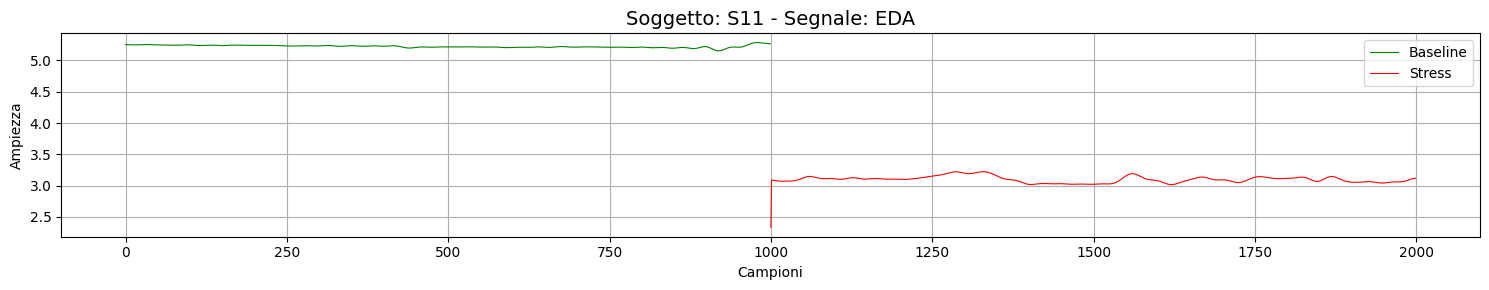

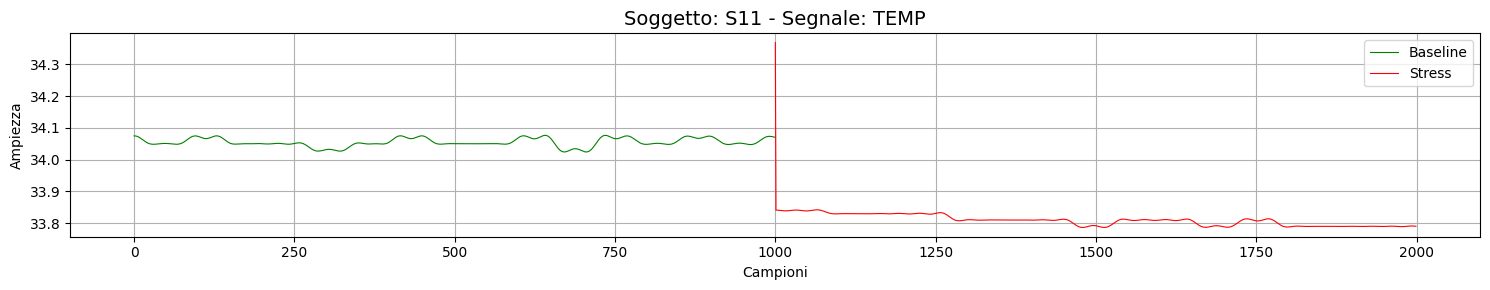


 Soggetto: S13


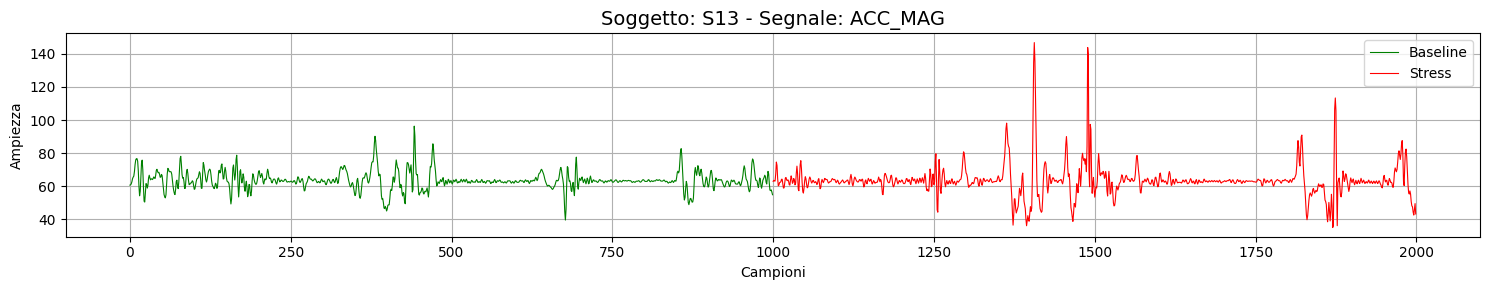

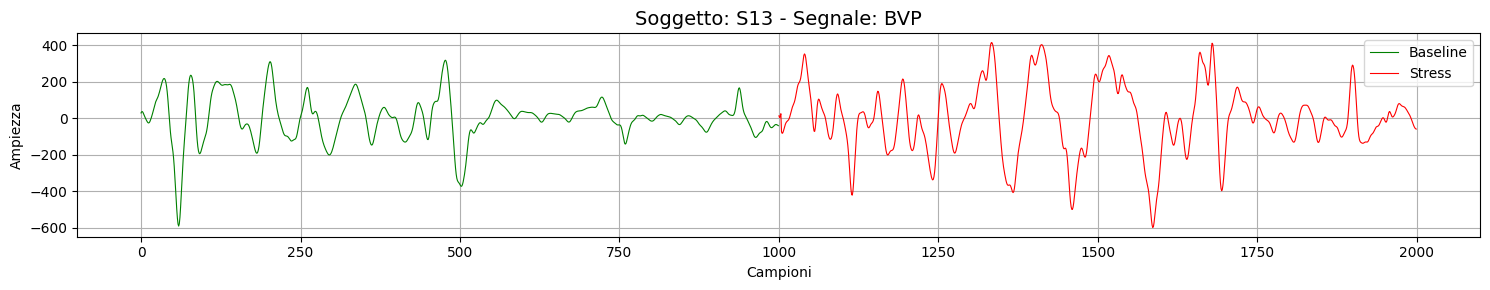

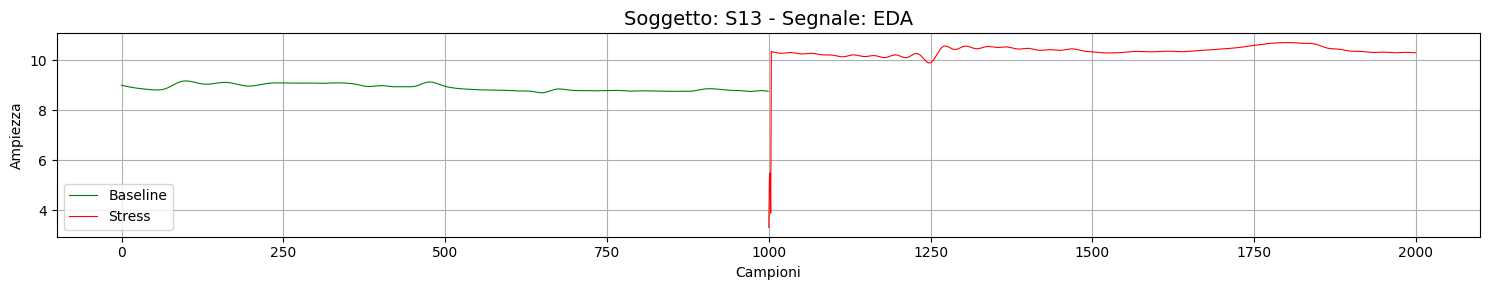

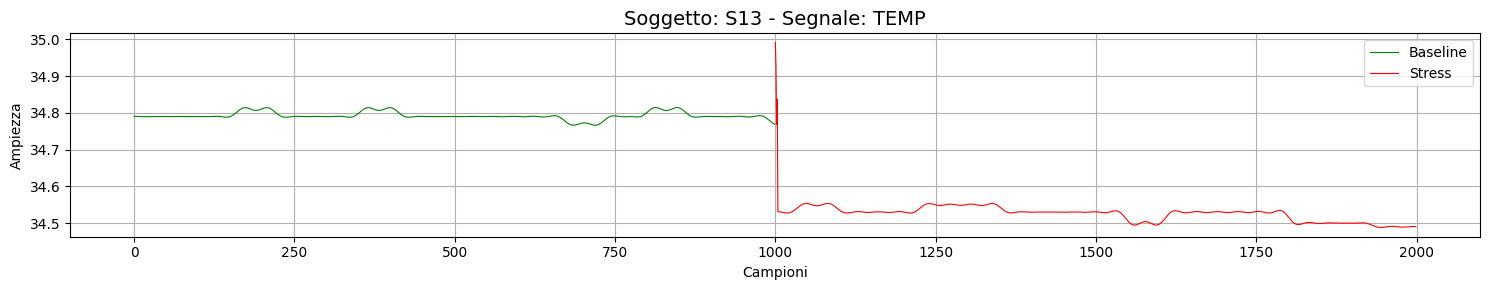


 Soggetto: S14


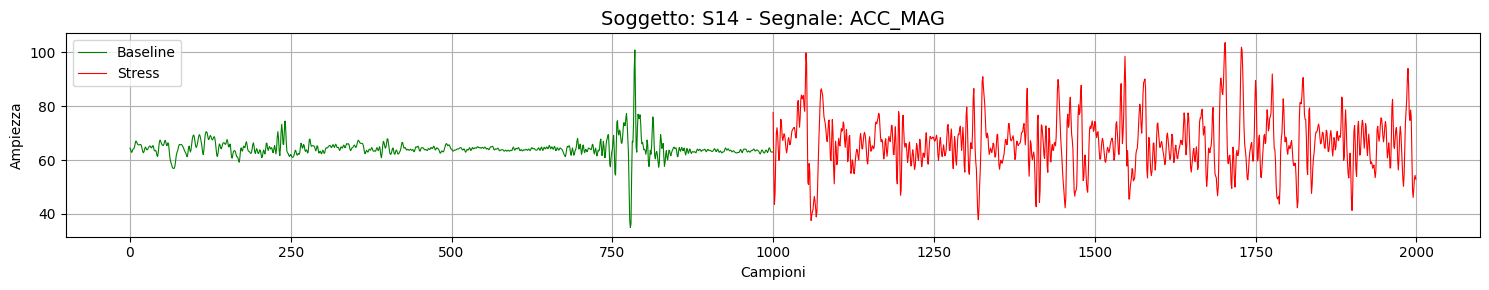

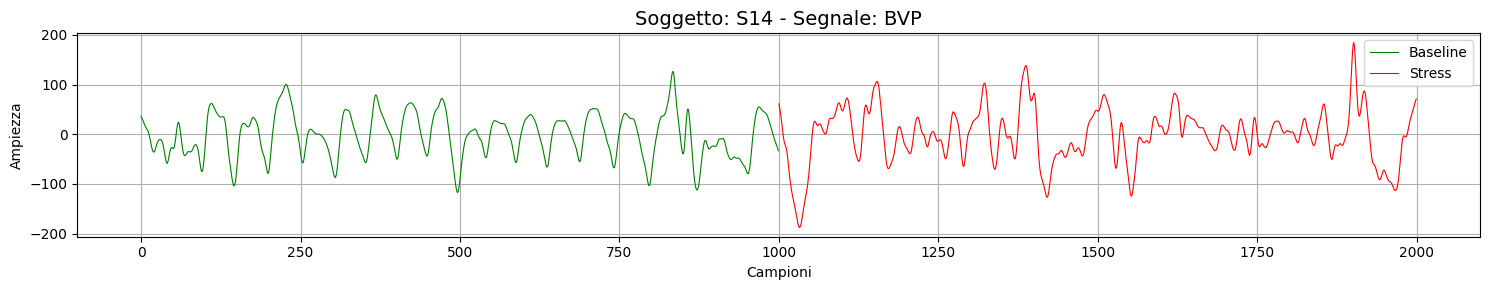

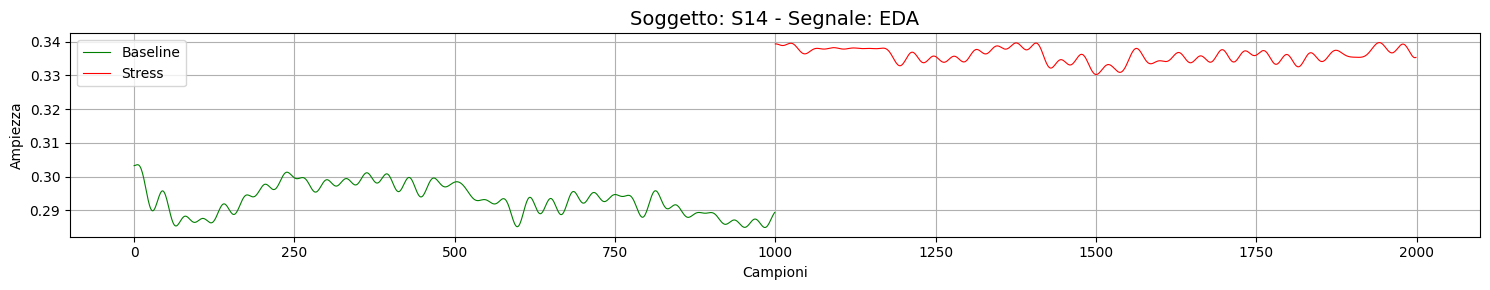

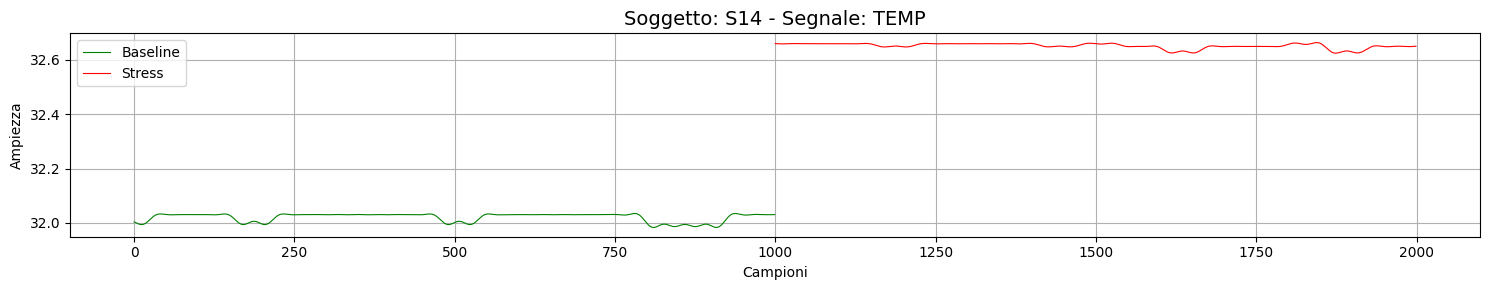


 Soggetto: S15


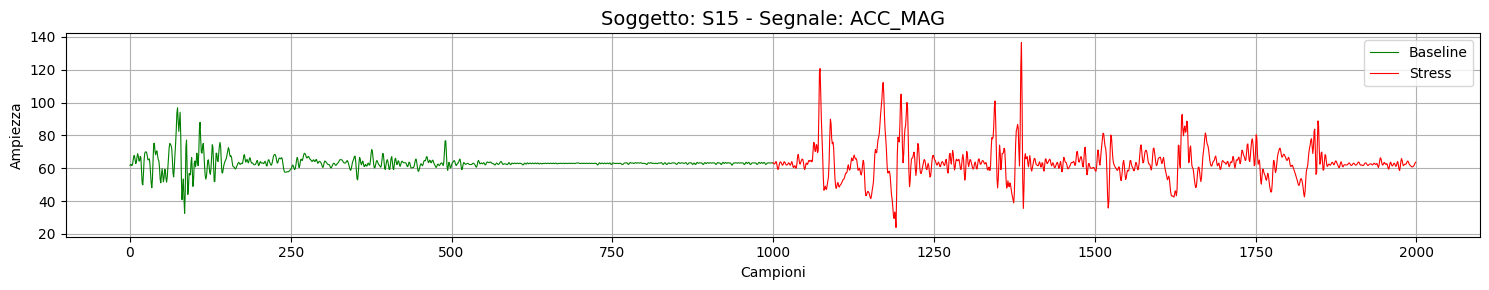

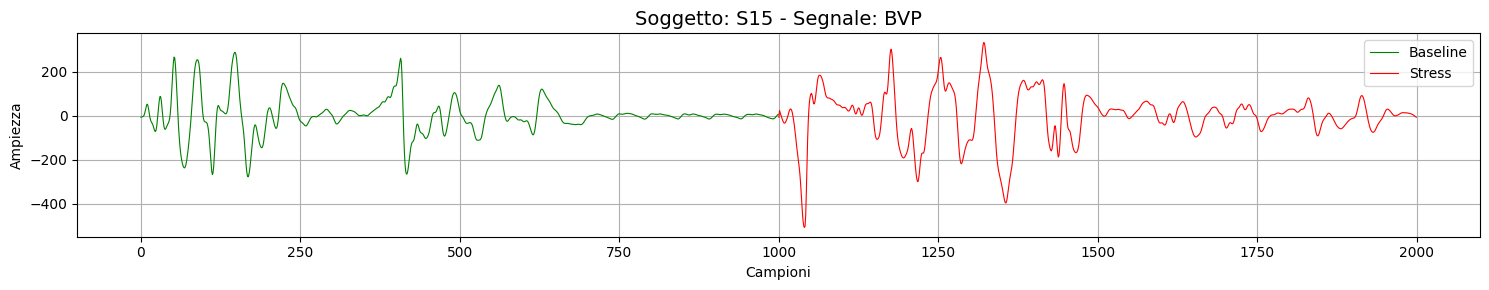

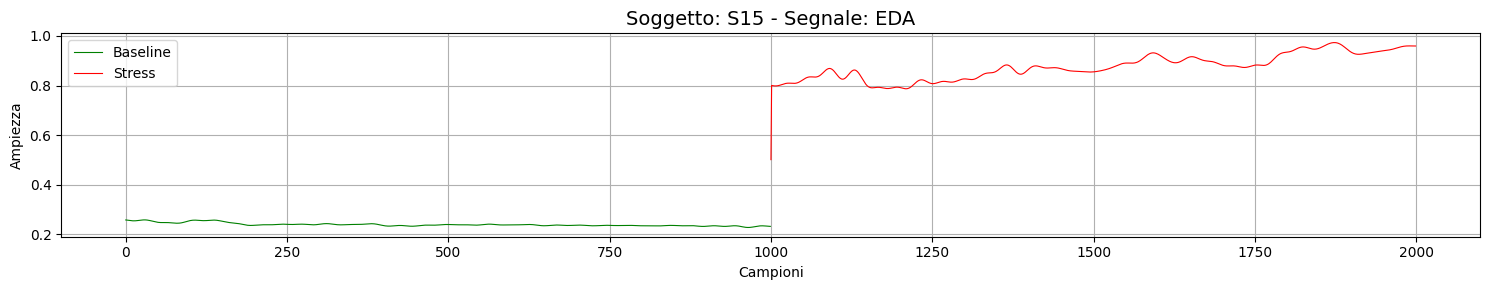

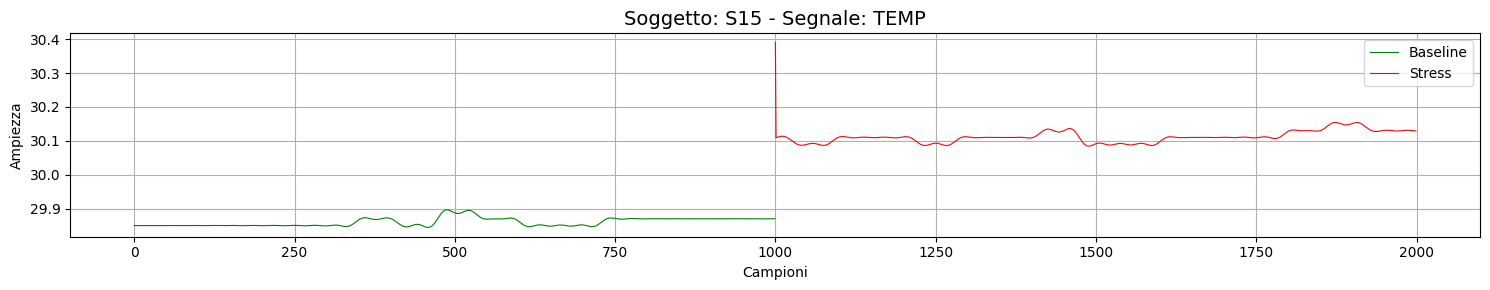


 Soggetto: S16


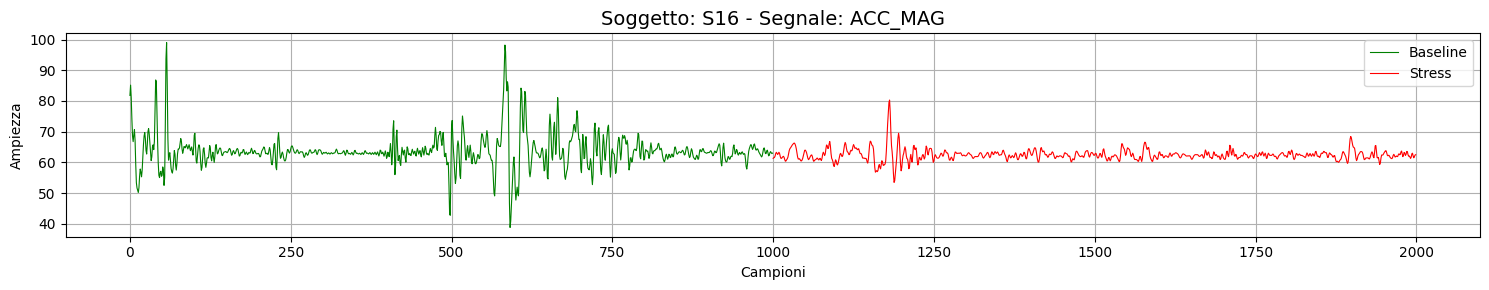

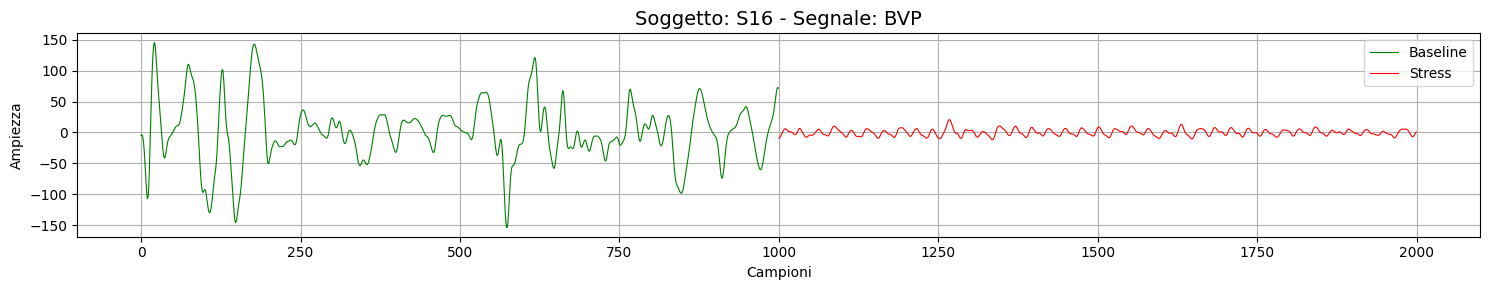

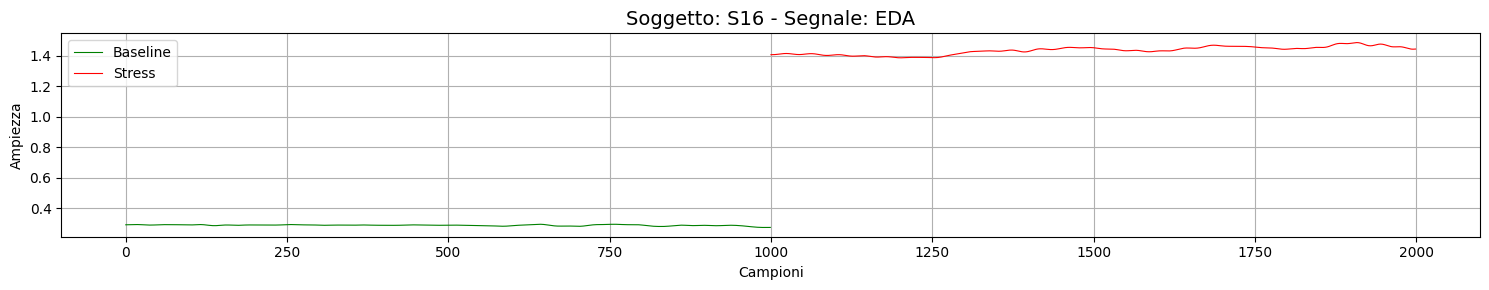

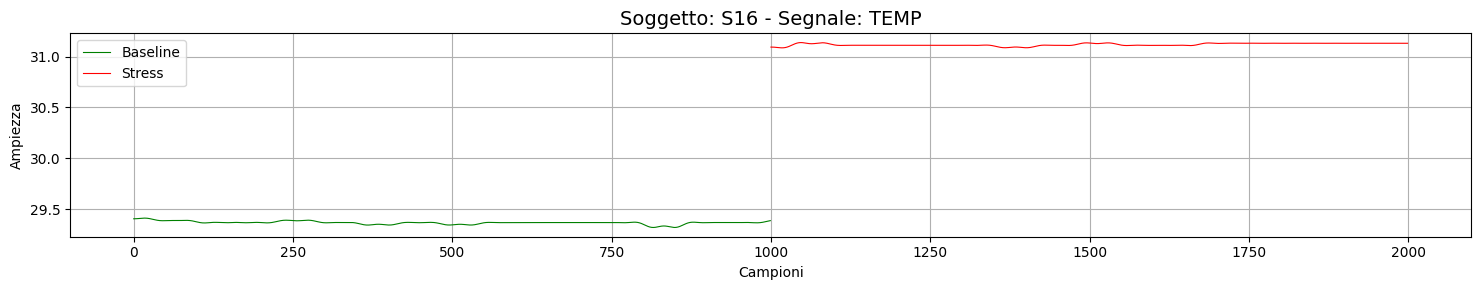


 Soggetto: S17


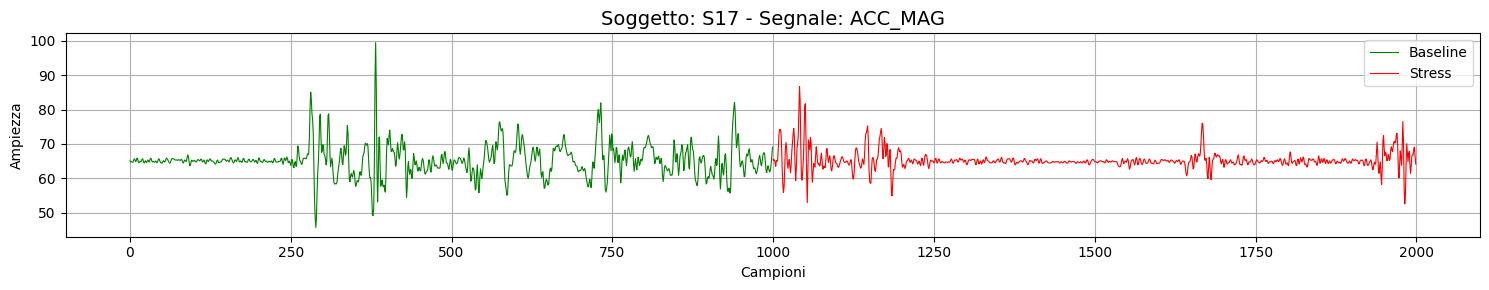

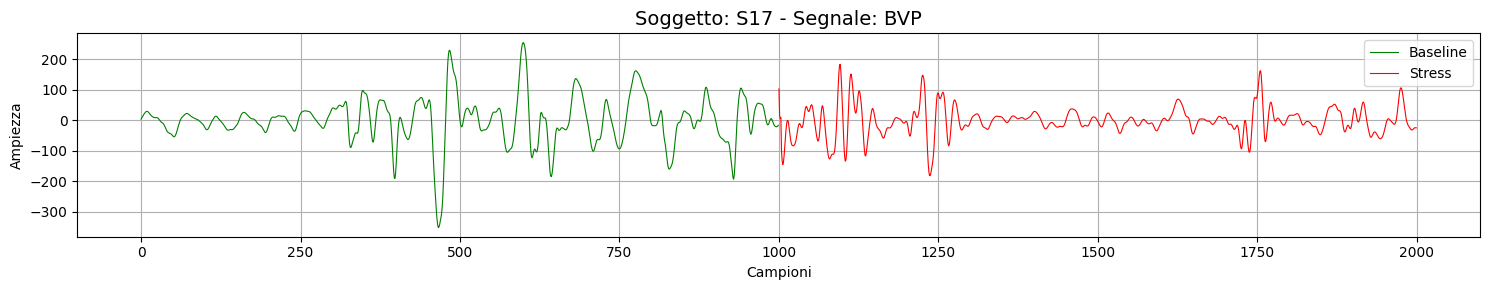

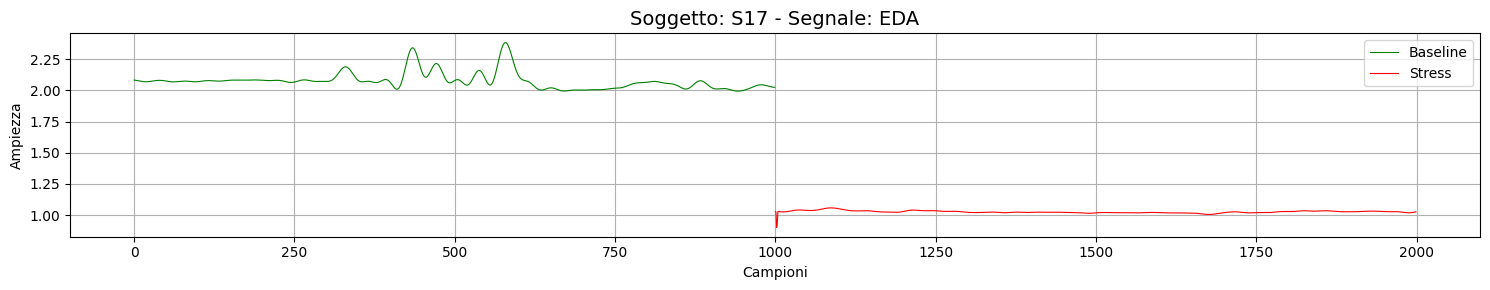

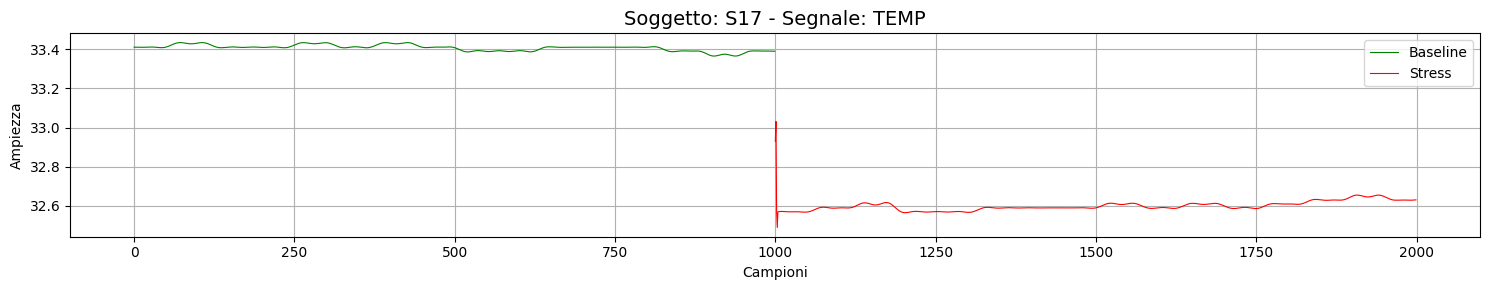

In [ ]:
plot_segnali_per_soggetto(df, n_points = 1000)

In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 39.7 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp'] = ppg_clean

In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_mag'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp'] = temp_denoise(df['temp'].values, fs)

In [ ]:
df['subject'].value_counts()

,count
subject,
S10,121927
S17,121865
S15,119110
S11,119048
S14,118721
S16,118596
S13,118025
S5,117959
S8,117704


In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.85):
    """
    Versione migliorata con soglia più alta e bilanciamento per soggetto
    """
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    # NUOVO: Statistiche per bilanciamento
    subject_stats = {}

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        # NUOVO: Raccogli finestre per classe
        subject_windows_0 = []
        subject_windows_1 = []

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # MODIFICATO: Soglia più alta per finestre più pure
            if dominant_ratio >= threshold:
                if dominant_label == 0:
                    subject_windows_0.append((window, dominant_label, subject_id))
                else:
                    subject_windows_1.append((window, dominant_label, subject_id))

        # NUOVO: Bilanciamento per soggetto
        n_class_0 = len(subject_windows_0)
        n_class_1 = len(subject_windows_1)

        if n_class_0 > 0 and n_class_1 > 0:
            # Prendi il minimo tra le due classi per bilanciare
            min_samples = min(n_class_0, n_class_1)

            # Limita a massimo 100 campioni per classe per soggetto
            min_samples = min(min_samples, 100)

            # Campiona casualmente
            if n_class_0 >= min_samples:
                selected_0 = np.random.choice(len(subject_windows_0), min_samples, replace=False)
            else:
                selected_0 = range(len(subject_windows_0))

            if n_class_1 >= min_samples:
                selected_1 = np.random.choice(len(subject_windows_1), min_samples, replace=False)
            else:
                selected_1 = range(len(subject_windows_1))

            # Aggiungi finestre selezionate
            for idx in selected_0:
                window, label, subject = subject_windows_0[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            for idx in selected_1:
                window, label, subject = subject_windows_1[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            subject_stats[subject_id] = {
                'classe_0': len(selected_0),
                'classe_1': len(selected_1),
                'totale_0_disponibili': n_class_0,
                'totale_1_disponibili': n_class_1
            }
        else:
            print(f"[SKIP] Soggetto {subject_id} - Classe 0: {n_class_0}, Classe 1: {n_class_1}")

    # NUOVO: Mostra statistiche bilanciamento
    print("\n=== STATISTICHE BILANCIAMENTO ===")
    for subject, stats in subject_stats.items():
        print(f"{subject}: 0={stats['classe_0']}/{stats['totale_0_disponibili']}, "
              f"1={stats['classe_1']}/{stats['totale_1_disponibili']}")

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['bvp', 'eda', 'acc_mag', 'temp']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.85  # Soglia più alta
    )
    if segnale == segnali[0]:
        y = y_raw
        group_labels = groups
    X_dict[segnale] = X

print(f"\nDataset finale: {len(y)} finestre")
print(f"Distribuzione classi: {np.unique(y, return_counts=True)}")

Processing bvp...

=== STATISTICHE BILANCIAMENTO ===
S2: 0=51/99, 1=51/51
S3: 0=54/98, 1=54/54
S4: 0=53/100, 1=53/53
S5: 0=54/104, 1=54/54
S6: 0=54/102, 1=54/54
S7: 0=54/103, 1=54/54
S8: 0=56/101, 1=56/56
S9: 0=54/102, 1=54/54
S10: 0=61/102, 1=61/61
S11: 0=57/102, 1=57/57
S13: 0=55/102, 1=55/55
S14: 0=56/102, 1=56/56
S15: 0=58/102, 1=58/58
S16: 0=56/102, 1=56/56
S17: 0=61/102, 1=61/61
Processing eda...

=== STATISTICHE BILANCIAMENTO ===
S2: 0=51/99, 1=51/51
S3: 0=54/98, 1=54/54
S4: 0=53/100, 1=53/53
S5: 0=54/104, 1=54/54
S6: 0=54/102, 1=54/54
S7: 0=54/103, 1=54/54
S8: 0=56/101, 1=56/56
S9: 0=54/102, 1=54/54
S10: 0=61/102, 1=61/61
S11: 0=57/102, 1=57/57
S13: 0=55/102, 1=55/55
S14: 0=56/102, 1=56/56
S15: 0=58/102, 1=58/58
S16: 0=56/102, 1=56/56
S17: 0=61/102, 1=61/61
Processing acc_mag...

=== STATISTICHE BILANCIAMENTO ===
S2: 0=51/99, 1=51/51
S3: 0=54/98, 1=54/54
S4: 0=53/100, 1=53/53
S5: 0=54/104, 1=54/54
S6: 0=54/102, 1=54/54
S7: 0=54/103, 1=54/54
S8: 0=56/101, 1=56/56
S9: 0=54/102, 1

In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione bvp: (1668, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione eda: (1668, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione acc_mag: (1668, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione temp: (1668, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (1668,)


In [ ]:
# Crea un DataFrame per l'analisi
df_windowed = pd.DataFrame({
    'subject': group_labels,  # questi sono i gruppi/soggetti per ogni finestra
    'label': y               # queste sono le label per ogni finestra
})

print(f"Dataset windowed: {len(df_windowed)} finestre totali")
print(f"Distribuzione globale: {np.unique(y, return_counts=True)}")

Dataset windowed: 1668 finestre totali
Distribuzione globale: (array([0, 1]), array([834, 834]))


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([834, 834]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

bvp: float32
eda: float32
acc_mag: float32
temp: float32


In [ ]:
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
logo = LeaveOneGroupOut()

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Concatenate, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.activations import sigmoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Add, Multiply, Reshape, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import ModelCheckpoint

BEST CNN TEST

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // reduction, activation='gelu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    return Multiply()([input_tensor, se])

In [ ]:
def conv_block_1d(input_signal):
    he_init = HeNormal()

    # Primo blocco semplice
    x = Conv1D(32, kernel_size=7, strides=1, padding='same', kernel_initializer=he_init)(input_signal)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4, strides=4)(x)
    x = SpatialDropout1D(0.3)(x)

    # Secondo blocco multi-scala
    conv3 = Conv1D(64, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    conv5 = Conv1D(64, kernel_size=5, padding='same', kernel_initializer=he_init)(x)
    conv7 = Conv1D(64, kernel_size=7, padding='same', kernel_initializer=he_init)(x)
    x = Concatenate()([conv3, conv5, conv7])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = SpatialDropout1D(0.3)(x)

    # Terzo blocco con residual
    shortcut = x
    y = Conv1D(128, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=2, strides=2)(y)
    shortcut = Conv1D(128, kernel_size=1, strides=2, padding='same', kernel_initializer=he_init)(shortcut)
    x = Add()([shortcut, y])
    x = SpatialDropout1D(0.3)(x)

    # Quarto blocco + SE + GAP/GMP
    x = Conv1D(256, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)

    # Quinto blocco aggiuntivo (nuovo)
    x = Conv1D(256, kernel_size=1, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(0.3)(x)

    # Pooling globale misto
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x)
    x = Concatenate()([gap, gmp])

    return x

In [ ]:
def build_cnn_model(input_shape=(2880, 1), n_signals=4):
    """
    CNN semplificata con migliore regolarizzazione
    """
    from tensorflow.keras.regularizers import l2

    he_init = HeNormal()
    inputs = []
    conv_outputs = []

    for _ in range(n_signals):
        inp = Input(shape=input_shape)

        # SEMPLIFICATO: Primo blocco
        x = Conv1D(32, kernel_size=7, strides=1, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(inp)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=4, strides=4)(x)
        x = SpatialDropout1D(0.2)(x)

        # SEMPLIFICATO: Secondo blocco
        x = Conv1D(64, kernel_size=5, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Terzo blocco
        x = Conv1D(128, kernel_size=3, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Solo Global Average Pooling
        x = GlobalAveragePooling1D()(x)

        inputs.append(inp)
        conv_outputs.append(x)

    # SEMPLIFICATO: Fusione e classificazione
    x = Concatenate()(conv_outputs)
    x = Dropout(0.5)(x)

    # RIDOTTO: Meno layer fully connected
    x = Dense(64, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(32, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss = -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

        return loss
    return focal_loss_fixed

CICLO LOSO

Trovati risultati esistenti per 13 soggetti: {'S16', 'S2', 'S11', 'S3', 'S7', 'S15', 'S10', 'S14', 'S17', 'S6', 'S13', 'S4', 'S5'}
Caricando dati globali esistenti...
Caricati 1448 campioni da esecuzioni precedenti
Caricati dettagli per 13 fold esistenti
=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===
== Fold 1 - S10 già completato, salto ==
== Fold 2 - S11 già completato, salto ==
== Fold 3 - S13 già completato, salto ==
== Fold 4 - S14 già completato, salto ==
== Fold 5 - S15 già completato, salto ==
== Fold 6 - S16 già completato, salto ==
== Fold 7 - S17 già completato, salto ==
== Fold 8 - S2 già completato, salto ==
== Fold 9 - S3 già completato, salto ==
== Fold 10 - S4 già completato, salto ==
== Fold 11 - S5 già completato, salto ==
== Fold 12 - S6 già completato, salto ==
== Fold 13 - S7 già completato, salto ==

FOLD 14 - SOGGETTO: S8
Train distribution: {np.int64(0): np.int64(778), np.int64(1): np.int64(778)}
Test distribution: {np.int64(0): np.int64(56), np.int64(1): np.in

98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - accuracy: 0.5447 - loss: 1.9908 - val_accuracy: 0.5000 - val_loss: 1.5967 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6118 - loss: 1.5331
Epoch 2: val_loss improved from 1.59667 to 1.24206, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 441ms/step - accuracy: 0.6118 - loss: 1.5322 - val_accuracy: 0.5000 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6283 - loss: 1.1912
Epoch 3: val_loss improved from 1.24206 to 0.97472, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.6284 - loss: 1.1904 - val_accuracy: 0.5000 - val_loss: 0.9747 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6867 - loss: 0.9192
Epoch 4: val_loss improved from 0.97472 to 0.75449, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.6866 - loss: 0.9186 - val_accuracy: 0.5268 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7279 - loss: 0.7125
Epoch 5: val_loss improved from 0.75449 to 0.59541, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.7277 - loss: 0.7121 - val_accuracy: 0.5446 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7101 - loss: 0.5553
Epoch 6: val_loss improved from 0.59541 to 0.46926, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.7102 - loss: 0.5550 - val_accuracy: 0.6339 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6832 - loss: 0.4456
Epoch 7: val_loss improved from 0.46926 to 0.36924, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.6834 - loss: 0.4453 - val_accuracy: 0.6875 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7415 - loss: 0.3505
Epoch 8: val_loss improved from 0.36924 to 0.30189, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7414 - loss: 0.3504 - val_accuracy: 0.7232 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7174 - loss: 0.2876
Epoch 9: val_loss improved from 0.30189 to 0.24511, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 427ms/step - accuracy: 0.7175 - loss: 0.2875 - val_accuracy: 0.7232 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7405 - loss: 0.2420
Epoch 10: val_loss improved from 0.24511 to 0.20552, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 440ms/step - accuracy: 0.7404 - loss: 0.2419 - val_accuracy: 0.7411 - val_loss: 0.2055 - learning_rate: 0.0010
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7283 - loss: 0.2029
Epoch 11: val_loss improved from 0.20552 to 0.17830, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 435ms/step - accuracy: 0.7283 - loss: 0.2028 - val_accuracy: 0.6607 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.7430 - loss: 0.1692
Epoch 12: val_loss improved from 0.17830 to 0.14661, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 455ms/step - accuracy: 0.7431 - loss: 0.1692 - val_accuracy: 0.8482 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7315 - loss: 0.1547
Epoch 13: val_loss improved from 0.14661 to 0.13623, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.7318 - loss: 0.1547 - val_accuracy: 0.6696 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7330 - loss: 0.1377
Epoch 14: val_loss improved from 0.13623 to 0.11286, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 442ms/step - accuracy: 0.7332 - loss: 0.1377 - val_accuracy: 0.8036 - val_loss: 0.1129 - learning_rate: 0.0010
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7542 - loss: 0.1241
Epoch 15: val_loss improved from 0.11286 to 0.10635, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 459ms/step - accuracy: 0.7543 - loss: 0.1241 - val_accuracy: 0.7679 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 16/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7670 - loss: 0.1106
Epoch 16: val_loss improved from 0.10635 to 0.08904, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 444ms/step - accuracy: 0.7669 - loss: 0.1106 - val_accuracy: 0.8482 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 17/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7733 - loss: 0.1007
Epoch 17: val_loss did not improve from 0.08904
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.7733 - loss: 0.1007 - val_accuracy: 0.5000 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 18/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7499 - loss: 0.0923
Epoch 18: val_loss improved from 0.08904 to 0.07055, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.7500 - loss: 0.0923 - val_accuracy: 0.9911 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 19/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7596 - loss: 0.0902
Epoch 19: val_loss did not improve from 0.07055
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 435ms/step - accuracy: 0.7597 - loss: 0.0902 - val_accuracy: 0.5000 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 20/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7608 - loss: 0.0838
Epoch 20: val_loss improved from 0.07055 to 0.06678, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - accuracy: 0.7607 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 21/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7683 - loss: 0.0786
Epoch 21: val_loss improved from 0.06678 to 0.04990, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.7682 - loss: 0.0786 - val_accuracy: 0.8482 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 22/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7760 - loss: 0.0768
Epoch 22: val_loss did not improve from 0.04990
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - accuracy: 0.7759 - loss: 0.0768 - val_accuracy: 0.9554 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 23/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7645 - loss: 0.0774
Epoch 23: val_loss did not improve from 0.04990
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7646 - loss: 0.0774 - val_accuracy: 1.0000 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 24/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7808 - loss: 0.0727
Epoch 24: val_loss improved from 0.04990 to 0.04496, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold14_S8.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.7807 - loss: 0.0727 - val_accuracy: 0.8839 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 25/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7841 - loss: 0.0678
Epoch 25: val_loss did not improve from 0.04496
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.7840 - loss: 0.0679 - val_accuracy: 0.8839 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 26/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7613 - loss: 0.0716
Epoch 26: val_loss did not improve from 0.04496
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 460ms/step - accuracy: 0.7614 - loss: 0.0716 - val_accuracy: 1.0000 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 27/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7730 - loss: 0.0668
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 27: val_loss did not improve from 0.04496
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 422ms/step - accuracy: 0.7730 - loss: 0.0669 - val_accuracy:

98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - accuracy: 0.5371 - loss: 1.9827 - val_accuracy: 0.5000 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5898 - loss: 1.5544
Epoch 2: val_loss improved from 1.61854 to 1.27171, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 450ms/step - accuracy: 0.5899 - loss: 1.5535 - val_accuracy: 0.5000 - val_loss: 1.2717 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6418 - loss: 1.2129
Epoch 3: val_loss improved from 1.27171 to 0.99858, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 436ms/step - accuracy: 0.6418 - loss: 1.2122 - val_accuracy: 0.5000 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6888 - loss: 0.9428
Epoch 4: val_loss improved from 0.99858 to 0.78579, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 469ms/step - accuracy: 0.6885 - loss: 0.9423 - val_accuracy: 0.5000 - val_loss: 0.7858 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6955 - loss: 0.7361
Epoch 5: val_loss improved from 0.78579 to 0.62183, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 449ms/step - accuracy: 0.6956 - loss: 0.7357 - val_accuracy: 0.5000 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7063 - loss: 0.5782
Epoch 6: val_loss improved from 0.62183 to 0.49226, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 446ms/step - accuracy: 0.7063 - loss: 0.5778 - val_accuracy: 0.5000 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7321 - loss: 0.4582
Epoch 7: val_loss improved from 0.49226 to 0.38854, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 458ms/step - accuracy: 0.7321 - loss: 0.4579 - val_accuracy: 0.5093 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7451 - loss: 0.3683
Epoch 8: val_loss improved from 0.38854 to 0.30595, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.7450 - loss: 0.3682 - val_accuracy: 0.5185 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7609 - loss: 0.3006
Epoch 9: val_loss improved from 0.30595 to 0.25609, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.7608 - loss: 0.3005 - val_accuracy: 0.6481 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7536 - loss: 0.2487
Epoch 10: val_loss improved from 0.25609 to 0.20971, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 456ms/step - accuracy: 0.7535 - loss: 0.2486 - val_accuracy: 0.5648 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7679 - loss: 0.2090
Epoch 11: val_loss did not improve from 0.20971
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 427ms/step - accuracy: 0.7678 - loss: 0.2089 - val_accuracy: 0.7870 - val_loss: 0.2115 - learning_rate: 0.0010
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7547 - loss: 0.1847
Epoch 12: val_loss improved from 0.20971 to 0.17858, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7547 - loss: 0.1846 - val_accuracy: 0.8333 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7500 - loss: 0.1563
Epoch 13: val_loss improved from 0.17858 to 0.13358, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.7501 - loss: 0.1562 - val_accuracy: 0.5185 - val_loss: 0.1336 - learning_rate: 0.0010
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7473 - loss: 0.1410
Epoch 14: val_loss improved from 0.13358 to 0.11823, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.7473 - loss: 0.1410 - val_accuracy: 0.7222 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7743 - loss: 0.1215
Epoch 15: val_loss did not improve from 0.11823
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.7743 - loss: 0.1214 - val_accuracy: 0.5093 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 16/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7739 - loss: 0.1121
Epoch 16: val_loss improved from 0.11823 to 0.10458, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 436ms/step - accuracy: 0.7739 - loss: 0.1120 - val_accuracy: 0.5556 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 17/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7757 - loss: 0.1038
Epoch 17: val_loss improved from 0.10458 to 0.09955, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 437ms/step - accuracy: 0.7757 - loss: 0.1038 - val_accuracy: 0.5000 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 18/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7652 - loss: 0.0972
Epoch 18: val_loss did not improve from 0.09955
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 430ms/step - accuracy: 0.7653 - loss: 0.0971 - val_accuracy: 0.7870 - val_loss: 0.1427 - learning_rate: 0.0010
Epoch 19/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7802 - loss: 0.0874
Epoch 19: val_loss improved from 0.09955 to 0.07267, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.7802 - loss: 0.0874 - val_accuracy: 0.6944 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 20/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7740 - loss: 0.0851
Epoch 20: val_loss improved from 0.07267 to 0.06854, saving model to /content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/best_model_fold15_S9.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - accuracy: 0.7740 - loss: 0.0851 - val_accuracy: 0.7315 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 21/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7794 - loss: 0.0777
Epoch 21: val_loss did not improve from 0.06854
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 443ms/step - accuracy: 0.7794 - loss: 0.0777 - val_accuracy: 0.8333 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 22/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7857 - loss: 0.0774
Epoch 22: val_loss did not improve from 0.06854
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 436ms/step - accuracy: 0.7856 - loss: 0.0774 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 23/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7698 - loss: 0.0717
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 23: val_loss did not improve from 0.06854
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.7700 - loss: 0.0717 - val_accuracy:

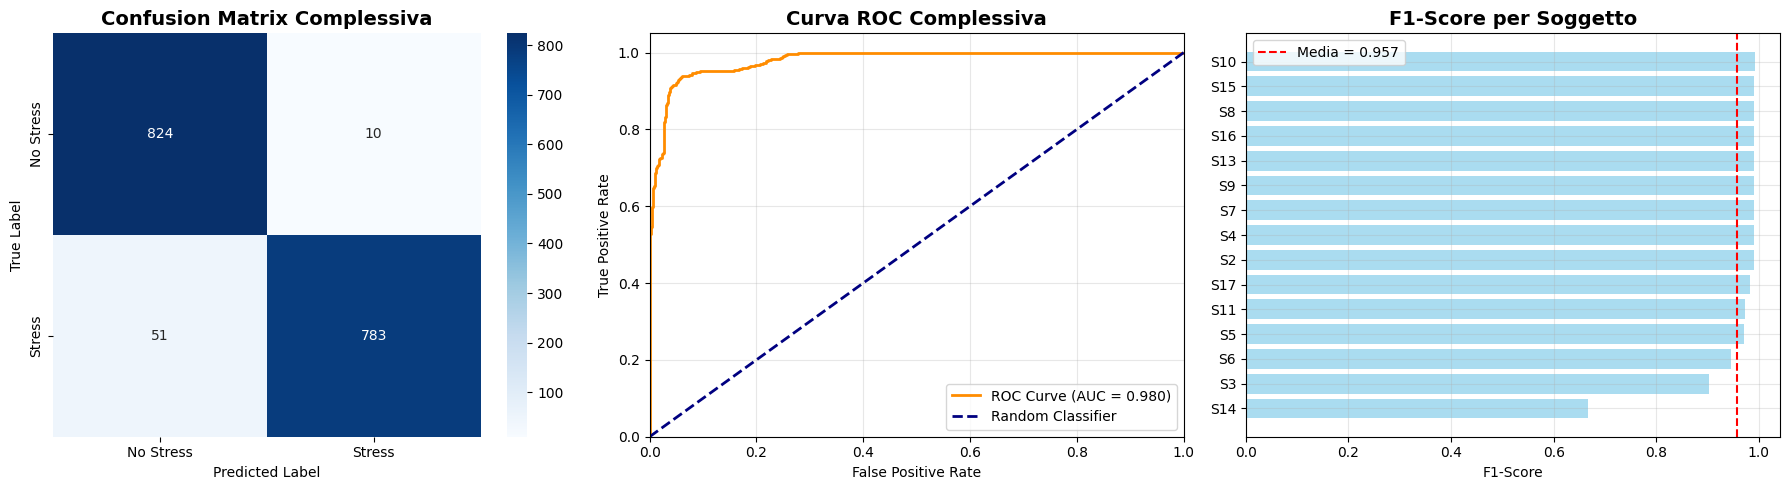


--------------------------------------------------
STATISTICHE FINALI
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
    S10        122    0.9918     1.0000  0.9836    0.9917
    S11        114    0.9737     0.9821  0.9649    0.9735
    S13        110    0.9909     1.0000  0.9818    0.9908
    S14        112    0.7500     1.0000  0.5000    0.6667
    S15        116    0.9914     1.0000  0.9828    0.9913
    S16        112    0.9911     1.0000  0.9821    0.9910
    S17        122    0.9836     0.9836  0.9836    0.9836
     S2        102    0.9902     1.0000  0.9804    0.9901
     S3        108    0.9074     0.9583  0.8519    0.9020
     S4        106    0.9906     1.0000  0.9811    0.9905
     S5        108    0.9722     0.9811  0.9630    0.9720
     S6        108    0.9444     0.9138  0.9815    0.9464
     S7        108    0.9907     1.0000  0.9815    0.9907
     S8        112    0.9911     1.0000  0

In [ ]:
# =============================================================================
# CICLO LOSO COMPLETO CON RECUPERO DATI GLOBALI E SALVATAGGIO PERSISTENTE
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
import pandas as pd
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

# === SETUP PATH ===
save_dir = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL"
os.makedirs(save_dir, exist_ok=True)
results_file = os.path.join(save_dir, "loso_results.csv")
global_data_file = os.path.join(save_dir, "loso_global_data.pkl")  # File per dati globali
fold_details_file = os.path.join(save_dir, "loso_fold_details.pkl")  # File per dettagli fold

best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
os.makedirs(best_model_dir, exist_ok=True)

# === FUNZIONE PER SALVARE DATI GLOBALI ===
def save_global_data(y_true, y_pred, y_proba, subjects, save_path):
    """Salva i dati globali per il calcolo delle metriche aggregate"""
    global_data = {
        'y_true': np.array(y_true),
        'y_pred': np.array(y_pred),
        'y_proba': np.array(y_proba),
        'subjects': subjects
    }
    with open(save_path, 'wb') as f:
        pickle.dump(global_data, f)
    print(f"Dati globali salvati in: {save_path}")

def load_global_data(save_path):
    """Carica i dati globali salvati"""
    try:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

def save_fold_details(fold_results, save_path):
    """Salva i dettagli dei fold"""
    with open(save_path, 'wb') as f:
        pickle.dump(fold_results, f)
    print(f"Dettagli fold salvati in: {save_path}")

def load_fold_details(save_path):
    """Carica i dettagli dei fold"""
    try:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

# === FUNZIONE PER RICOSTRUIRE DATI GLOBALI DA MODELLI SALVATI ===
def reconstruct_global_data_from_models(completed_subjects, save_dir, X_dict, y, groups, segnali):
    """Ricostruisce i dati globali eseguendo predict sui modelli già salvati"""
    print("=== RICOSTRUZIONE DATI GLOBALI DA MODELLI SALVATI ===")

    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    all_subjects = []

    for subject in completed_subjects:
        print(f"Ricostruendo dati per soggetto: {subject}")

        # Trova il modello salvato per questo soggetto
        model_pattern = os.path.join(save_dir, f"best_model_fold*_{subject}.h5")
        import glob
        model_files = glob.glob(model_pattern)

        if not model_files:
            print(f"  [WARNING] Modello non trovato per {subject}")
            continue

        model_path = model_files[0]

        try:
            # Trova i dati di test per questo soggetto
            subject_indices = np.where(groups == subject)[0]

            if len(subject_indices) == 0:
                print(f"  [WARNING] Nessun dato trovato per {subject}")
                continue

            # Prepara i dati di test
            test_inputs = []
            for seg in segnali:
                X_seg = X_dict[seg]
                X_test_seg = X_seg[subject_indices]

                N_test, T = X_test_seg.shape[:2]
                X_test_flat = X_test_seg.reshape(N_test, T)

                # Usa scaler semplice (idealmente dovremmo salvare anche gli scaler)
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                X_test_scaled = scaler.fit_transform(X_test_flat)
                test_inputs.append(X_test_scaled[..., np.newaxis])

            y_test = y[subject_indices]

            # Carica e usa il modello
            model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
            model.load_weights(model_path)

            # Predizione
            y_pred_proba = model.predict(test_inputs, verbose=0)
            if len(y_pred_proba.shape) > 1:
                y_pred_proba = y_pred_proba.flatten()

            # Usa soglia 0.5 come default (idealmente dovremmo salvare anche le soglie)
            y_pred = (y_pred_proba > 0.5).astype(int)

            # Accumula dati
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_proba.extend(y_pred_proba)
            all_subjects.extend([subject] * len(y_test))

            print(f"  ✓ Ricostruiti {len(y_test)} campioni per {subject}")

        except Exception as e:
            print(f"  [ERROR] Errore nella ricostruzione per {subject}: {e}")
            continue

    return all_y_true, all_y_pred, all_y_proba, all_subjects

# === CARICA PROGRESSI SE ESISTENTI ===
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    completed_subjects = set(results_df['subject'])
    print(f"Trovati risultati esistenti per {len(completed_subjects)} soggetti: {completed_subjects}")
else:
    results_df = pd.DataFrame()
    completed_subjects = set()

# Carica dati globali esistenti
global_data_existing = load_global_data(global_data_file)
fold_results_existing = load_fold_details(fold_details_file)

# === INIZIALIZZAZIONE VARIABILI PER RACCOLTA METRICHE ===
reports = []
best_f1_score = 0
best_model_info = None

# VARIABILI PER METRICHE AGGREGATE
if global_data_existing is not None:
    print("Caricando dati globali esistenti...")
    all_y_true_global = list(global_data_existing['y_true'])
    all_y_pred_global = list(global_data_existing['y_pred'])
    all_y_proba_global = list(global_data_existing['y_proba'])
    all_subjects_global = list(global_data_existing['subjects'])
    print(f"Caricati {len(all_y_true_global)} campioni da esecuzioni precedenti")
else:
    # Se non esistono dati globali ma ci sono soggetti completati, prova a ricostruire
    if completed_subjects:
        print("Tentativo di ricostruzione dati globali da modelli esistenti...")
        all_y_true_global, all_y_pred_global, all_y_proba_global, all_subjects_global = \
            reconstruct_global_data_from_models(completed_subjects, save_dir, X_dict, y, groups, segnali)
    else:
        all_y_true_global = []
        all_y_pred_global = []
        all_y_proba_global = []
        all_subjects_global = []

# Carica dettagli fold esistenti
if fold_results_existing:
    fold_results = fold_results_existing
    print(f"Caricati dettagli per {len(fold_results)} fold esistenti")
else:
    fold_results = []

print("=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===")

# === CICLO LOSO PRINCIPALE ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]

    if subject_name in completed_subjects:
        print(f"== Fold {fold+1} - {subject_name} già completato, salto ==")
        continue

    print(f"\n{'='*50}")
    print(f"FOLD {fold+1} - SOGGETTO: {subject_name}")
    print(f"{'='*50}")

    # === PREPARAZIONE DATI ===
    train_inputs = []
    test_inputs = []
    scalers = []

    for seg in segnali:
        X_seg = X_dict[seg]
        X_train_seg = X_seg[train_idx]
        X_test_seg = X_seg[test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.transform(X_test_flat)

        scalers.append(scaler)
        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train = y[train_idx]
    y_test = y[test_idx]

    # === VERIFICA BILANCIAMENTO ===
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    print(f"Train distribution: {dict(zip(unique_train, counts_train))}")
    print(f"Test distribution: {dict(zip(unique_test, counts_test))}")

    # Skip se il test set ha una sola classe
    if len(unique_test) < 2:
        print(f"[SKIP] Test set ha una sola classe per {subject_name}")
        continue

    # === CALCOLA CLASS WEIGHTS ===
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights: {class_weight_dict}")

    # === COSTRUISCI E COMPILA MODELLO ===
    model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    # === CALLBACKS ===
    early_stopper = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    checkpoint_path = os.path.join(save_dir, f"best_model_fold{fold+1}_{subject_name}.h5")
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # === ADDESTRAMENTO ===
    print("Inizio training...")
    try:
        history = model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=50,
            batch_size=16,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler, checkpoint],
            verbose=1
        )
    except Exception as e:
        print(f"[ERROR] Training fallito per {subject_name}: {e}")
        continue

    # === CARICA MIGLIOR MODELLO ===
    try:
        model.load_weights(checkpoint_path)
    except Exception as e:
        print(f"[ERROR] Impossibile caricare weights per {subject_name}: {e}")
        continue

    # === PREDIZIONE ===
    print("Predizione e valutazione...")
    try:
        y_pred_proba = model.predict(test_inputs, verbose=0)

        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Trova soglia ottimale
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

    except Exception as e:
        print(f"[ERROR] Predizione fallita per {subject_name}: {e}")
        continue

    # === CALCOLO METRICHE INDIVIDUALI ===
    try:
        acc = float(accuracy_score(y_test, y_pred))
        prec = float(precision_score(y_test, y_pred, zero_division=0))
        rec = float(recall_score(y_test, y_pred, zero_division=0))
        f1 = float(f1_score(y_test, y_pred, zero_division=0))
        optimal_threshold = float(optimal_threshold)

    except Exception as e:
        print(f"[ERROR] Calcolo metriche fallito per {subject_name}: {e}")
        continue

    # === STAMPA RISULTATI INDIVIDUALI ===
    print(f"\n--- RISULTATI FOLD {fold+1} - {subject_name} ---")
    print(f"Soglia ottimale: {optimal_threshold:.3f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # === CLASSIFICATION REPORT PER SOGGETTO ===
    print(f"\n--- CLASSIFICATION REPORT - {subject_name} ---")
    try:
        print(classification_report(y_test, y_pred, zero_division=0,
                                  target_names=['No Stress', 'Stress']))

        print(f"\n--- CONFUSION MATRIX - {subject_name} ---")
        cm_individual = confusion_matrix(y_test, y_pred)
        print(cm_individual)

    except Exception as e:
        print(f"[WARNING] Report dettagliato fallito: {e}")

    # === ACCUMULA DATI PER METRICHE GLOBALI ===
    all_y_true_global.extend(y_test)
    all_y_pred_global.extend(y_pred)
    all_y_proba_global.extend(y_pred_proba)
    all_subjects_global.extend([subject_name] * len(y_test))

    # === SALVA DETTAGLI FOLD ===
    fold_results.append({
        'fold': fold + 1,
        'subject': subject_name,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'optimal_threshold': optimal_threshold,
        'class_0_count': int(np.sum(y_test == 0)),
        'class_1_count': int(np.sum(y_test == 1))
    })

    # === VERIFICA MIGLIOR MODELLO ===
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_info = {
            'fold': int(fold + 1),
            'subject': str(subject_name),
            'f1_score': float(f1),
            'accuracy': float(acc),
            'precision': float(prec),
            'recall': float(rec),
            'optimal_threshold': float(optimal_threshold),
            'model_path': str(checkpoint_path),
            'scalers': scalers.copy()
        }
        print(f"*** NUOVO MIGLIOR MODELLO: F1={f1:.4f} ***")

    # === SALVA RISULTATI ===
    result_row = {
        'subject': str(subject_name),
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1_score': float(f1),
        'optimal_threshold': float(optimal_threshold)
    }

    reports.append(result_row)

    try:
        pd.DataFrame([result_row]).to_csv(
            results_file,
            mode='a',
            index=False,
            header=not os.path.exists(results_file)
        )
        print(f"Risultati salvati per {subject_name}")
    except Exception as e:
        print(f"[WARNING] Salvataggio CSV fallito per {subject_name}: {e}")

    # === SALVA DATI GLOBALI INCREMENTALMENTE ===
    save_global_data(all_y_true_global, all_y_pred_global, all_y_proba_global,
                     all_subjects_global, global_data_file)
    save_fold_details(fold_results, fold_details_file)

    # === PULIZIA MEMORIA ===
    try:
        del model, history, y_pred_proba, y_pred
        tf.keras.backend.clear_session()
    except:
        pass

# === CARICA TUTTI I RISULTATI FINALI ===
print(f"\n{'='*70}")
print("CARICAMENTO RISULTATI COMPLETI")
print(f"{'='*70}")

# Ricarica tutti i risultati dal CSV
if os.path.exists(results_file):
    all_results_df = pd.read_csv(results_file)
    print(f"Caricati risultati per {len(all_results_df)} soggetti totali")
else:
    all_results_df = pd.DataFrame()

# Ricarica dati globali finali
final_global_data = load_global_data(global_data_file)
final_fold_details = load_fold_details(fold_details_file)

if final_global_data is not None:
    all_y_true_global = final_global_data['y_true']
    all_y_pred_global = final_global_data['y_pred']
    all_y_proba_global = final_global_data['y_proba']
    all_subjects_global = final_global_data['subjects']
    fold_results = final_fold_details if final_fold_details else fold_results

# === SALVA MIGLIOR MODELLO ===
if best_model_info is not None:
    print(f"\n=== SALVATAGGIO MIGLIOR MODELLO ===")
    print(f"Miglior F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

    try:
        best_model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
        best_model.load_weights(best_model_info['model_path'])

        best_model_path = os.path.join(best_model_dir, "best_model.keras")
        best_model.save(best_model_path)

        import joblib
        scalers_path = os.path.join(best_model_dir, "scalers.pkl")
        joblib.dump(best_model_info['scalers'], scalers_path)

        best_info_path = os.path.join(best_model_dir, "best_model_info.json")

        model_info = {
            'fold': best_model_info['fold'],
            'subject': best_model_info['subject'],
            'f1_score': best_model_info['f1_score'],
            'accuracy': best_model_info['accuracy'],
            'precision': best_model_info['precision'],
            'recall': best_model_info['recall'],
            'optimal_threshold': best_model_info['optimal_threshold']
        }

        with open(best_info_path, 'w') as f:
            json.dump(model_info, f, indent=2)

        print(f"Miglior modello salvato in: {best_model_path}")
        print(f"Scaler salvati in: {scalers_path}")
        print(f"Informazioni salvate in: {best_info_path}")

    except Exception as e:
        print(f"[ERROR] Salvataggio miglior modello fallito: {e}")

# =============================================================================
# VISUALIZZAZIONE METRICHE AGGREGATE COMPLETE
# =============================================================================

print(f"\n{'='*70}")
print("VALUTAZIONE COMPLESSIVA CICLO LOSO - TUTTI I SOGGETTI")
print(f"{'='*70}")

print(f"Campioni totali raccolti: {len(all_y_true_global)}")
print(f"Soggetti processati: {len(fold_results) if fold_results else 0}")
if len(all_y_true_global) > 0:
    print(f"Distribuzione classi globale: No Stress={np.sum(all_y_true_global == 0)}, Stress={np.sum(all_y_true_global == 1)}")

# === 1. CLASSIFICATION REPORT COMPLESSIVO ===
print(f"\n{'-'*50}")
print("CLASSIFICATION REPORT COMPLESSIVO")
print(f"{'-'*50}")

if len(all_y_true_global) > 0:
    global_report = classification_report(
        all_y_true_global, all_y_pred_global,
        zero_division=0,
        target_names=['No Stress', 'Stress']
    )
    print(global_report)

    # === 2. CONFUSION MATRIX COMPLESSIVA ===
    print(f"\n{'-'*50}")
    print("CONFUSION MATRIX COMPLESSIVA")
    print(f"{'-'*50}")

    cm_global = confusion_matrix(all_y_true_global, all_y_pred_global)
    print("Confusion Matrix (Counts):")
    print(cm_global)

    # Percentuali
    cm_percent = cm_global.astype('float') / cm_global.sum(axis=1)[:, np.newaxis] * 100
    print("\nConfusion Matrix (Percentages):")
    print(f"[[{cm_percent[0,0]:.1f}% {cm_percent[0,1]:.1f}%]")
    print(f" [{cm_percent[1,0]:.1f}% {cm_percent[1,1]:.1f}%]]")

    # Visualizzazione grafica
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix Complessiva', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # === 3. CURVA ROC COMPLESSIVA ===
    fpr, tpr, _ = roc_curve(all_y_true_global, all_y_proba_global)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Complessiva', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    print(f"\n{'-'*50}")
    print("CURVA ROC COMPLESSIVA")
    print(f"{'-'*50}")
    print(f"AUC (Area Under Curve): {roc_auc:.4f}")

    # === 4. PERFORMANCE PER SOGGETTO ===
    if fold_results:
        fold_df = pd.DataFrame(fold_results)
        fold_df_sorted = fold_df.sort_values('f1_score', ascending=True)

        axes[2].barh(fold_df_sorted['subject'], fold_df_sorted['f1_score'],
                     color='skyblue', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3)

        # Aggiungi linea media
        mean_f1 = fold_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--',
                        label=f'Media = {mean_f1:.3f}')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

# === STATISTICHE FINALI ===
print(f"\n{'-'*50}")
print("STATISTICHE FINALI")
print(f"{'-'*50}")

if fold_results:
    fold_df = pd.DataFrame(fold_results)

    print("Risultati per soggetto:")
    print(fold_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False, float_format='%.4f'))

    print(f"\nStatistiche aggregate:")
    print(f"F1-Score medio: {fold_df['f1_score'].mean():.4f} ± {fold_df['f1_score'].std():.4f}")
    print(f"Accuracy media: {fold_df['accuracy'].mean():.4f} ± {fold_df['accuracy'].std():.4f}")
    print(f"Precision media: {fold_df['precision'].mean():.4f} ± {fold_df['precision'].std():.4f}")
    print(f"Recall medio: {fold_df['recall'].mean():.4f} ± {fold_df['recall'].std():.4f}")

    print(f"\nRange performance:")
    print(f"F1-Score: {fold_df['f1_score'].min():.4f} - {fold_df['f1_score'].max():.4f}")
    print(f"Miglior soggetto: {fold_df.loc[fold_df['f1_score'].idxmax(), 'subject']} (F1={fold_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {fold_df.loc[fold_df['f1_score'].idxmin(), 'subject']} (F1={fold_df['f1_score'].min():.4f})")

print(f"\n{'='*70}")
print("CICLO LOSO COMPLETATO!")
print(f"{'='*70}")